## 此專案用於開發 RUL 預測程式的最終版本, 此處先以單點分析再推廣至多工況 ##
### 此程式用於進一步調整 Vin Iout vs I in I out 兩種不同物理量輸入模型之差異 (也比較好解釋) ###
### 模型採用 經典的CNN 模型 但使用 wide input 與 multiscale brach 來更好的抓取訊號 ###
### 2025 0815 ###



### 導入模型設定與套件 ###

In [1]:
# import used functioons 
#  import tools 
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate, RepeatVector, MaxPooling1D, Activation ,UpSampling1D, Conv1DTranspose
from tensorflow.keras.layers import Add, Concatenate,LSTM, TimeDistributed, MultiHeadAttention, LayerNormalization


from tensorflow.keras.utils import plot_model

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU devices found:")
    for gpu in gpus:
        print(gpu)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed

from rul_features.rul_data_read import read_rul_data

from test_algs.CCAE_ntu_rul import get_initial_files_datalist, CCAE_train
from test_algs.CCAE_ntu_rul import CCAE_model_application, CCAE_model_build_train

import random
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(42)



GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### 確立訓練工況檔案來源 ###
使用 CCAE 範本作為正常工況

In [2]:

from datetime import datetime
import json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense, Average, Add, Multiply, Lambda, GlobalAveragePooling1D
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model


# Initial model parameters
sequence_length=1024
layer_number=1
future_length=512

model_folder_path = r'NTU_rul_models\CCAE_models'
model_name = f'0820_multiscale_CCAE_Base{sequence_length}Future{future_length}'
model_path = os.path.join(model_folder_path, model_name)
os.makedirs(model_path, exist_ok=True)

from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, TimeDistributed, AdditiveAttention

# def build_cnn_multi_branch_ae(
#     input_dim_list,
#     sequence_length,
#     condition_dim,
#     model_folder_path=None,
#     model_name=None,
#     iscondition=True,
#     # 第一層（分支前）設定
#     first_kernel_size=64,      # 第一層 kernel size
#     first_layer_filters=None,  # 若為 None，預設用 base_filters
#     first_stride=1,            # 第一層 stride（可自訂）
#     # 分支 kernels（每個分支全程沿用自己的 k）
#     first_branch_kernels=(3, 5, 7),
#     # 既有參數
#     base_filters=32,
#     blocks=3,
#     decay=0.5,
#     filters_per_block=None,
#     # 反捲積（還原第一層 stride）kernel，預設沿用 first_kernel_size
#     deconv_kernel_size=None
# ):
#     """
#     - Stem：Conv1D(filters=first_layer_filters, kernel_size=first_kernel_size, strides=first_stride, padding='same')
#     - Encoder（多分支）：各分支全程用自己的 k；每層 strides=2
#     - Bottleneck：Conv1D(k, stride=1)
#     - Decoder（多分支）：UpSampling(2)+Conv1D(k, stride=1)
#     - Merge 後：只做 1x1 Conv 融合（已移除 3x1 fusion conv）
#     - 還原第一層 stride：以「每通道 Conv1DTranspose」(groups=channels, stride=first_stride)
#     - 最後裁切回 sequence_length
#     """
#     from tensorflow.keras.layers import (
#         Input, Concatenate, Conv1D, Dense, UpSampling1D,
#         RepeatVector, Lambda
#     )
#     from tensorflow.keras.models import Model
#     import tensorflow as tf

#     try:
#         from tensorflow.keras.layers import Conv1DTranspose
#     except Exception as e:
#         raise ImportError(
#             "需要 tf.keras.layers.Conv1DTranspose（建議 TF/Keras 2.15+/Keras3）。"
#         ) from e

#     assert blocks >= 1, "blocks 必須 >= 1"
#     assert first_stride >= 1 and int(first_stride) == first_stride, "first_stride 必須為正整數"

#     if filters_per_block is not None:
#         assert len(filters_per_block) >= blocks, "filters_per_block 長度需 >= blocks"
#         f_list = [int(max(1, f)) for f in filters_per_block[:blocks]]
#     else:
#         f_list = [int(max(1, round(base_filters * (decay ** i)))) for i in range(blocks)]

#     if deconv_kernel_size is None:
#         deconv_kernel_size = first_kernel_size

#     # === Series Inputs ===
#     inputs = []
#     for idx, input_dim in enumerate(input_dim_list):
#         inputs.append(Input(shape=(sequence_length, input_dim), name=f'series_{idx}'))
#     series_input = inputs[0] if len(inputs) == 1 else Concatenate(axis=-1, name='series_input_concat')(inputs)

#     # === Condition inputs ===
#     condition_input_1 = Input(shape=(condition_dim,), name='condition_1')
#     condition_input_2 = Input(shape=(condition_dim,), name='condition_2')
#     merged_condition = Concatenate(name="merged_condition")([condition_input_1, condition_input_2])

#     # === (Optional) repeat condition and concat ===
#     x_in = series_input
#     if iscondition:
#         repeated_condition = RepeatVector(sequence_length, name="cond_repeat")(merged_condition)
#         x_in = Concatenate(axis=-1, name='series_with_condition')([x_in, repeated_condition])

#     # === Stem：Conv1D(k=first_kernel_size, s=first_stride) ===
#     if first_layer_filters is None:
#         first_layer_filters = base_filters
#     stem = Conv1D(
#         filters=first_layer_filters,
#         kernel_size=first_kernel_size,
#         strides=first_stride,
#         padding='same',
#         activation='relu',
#         name=f'stem_conv_k{first_kernel_size}_s{first_stride}'
#     )(x_in)

#     # === 每個分支一路用自己的 k；encoder strides=2，decoder 上採樣 2 ===
#     def cnn_branch(x, k, name_prefix):
#         z = x
#         for b in range(blocks):
#             z = Conv1D(
#                 filters=f_list[b], kernel_size=k, strides=2,
#                 padding='same', activation='relu',
#                 name=f'{name_prefix}_enc_c{b+1}_k{k}_s2'
#             )(z)
#         z = Conv1D(
#             filters=f_list[-1], kernel_size=k, strides=1,
#             padding='same', activation='relu',
#             name=f'{name_prefix}_bottleneck_k{k}'
#         )(z)
#         for b in reversed(range(blocks)):
#             z = UpSampling1D(size=2, name=f'{name_prefix}_dec_u{blocks-b}_x2')(z)
#             z = Conv1D(
#                 filters=f_list[b], kernel_size=k, strides=1,
#                 padding='same', activation='relu',
#                 name=f'{name_prefix}_dec_c{blocks-b}_k{k}'
#             )(z)
#         return z

#     branch_outputs = [cnn_branch(stem, k, name_prefix=f'branch_k{k}') for k in first_branch_kernels]

#     merged = Concatenate(axis=-1, name='decoder_branches_concat')(branch_outputs)

#     # === 只保留 1x1 融合層（移除 3x1 fusion conv） ===
#     fuse_width = max(f_list[0], first_layer_filters, base_filters)
#     fused = Conv1D(fuse_width, 1, padding='same', activation='relu', name='fusion_conv1x1')(merged)

#     # === 每通道 Conv1DTranspose 還原第一層 stride ===
#     if first_stride > 1:
#         fused = Conv1DTranspose(
#             filters=fuse_width,
#             kernel_size=deconv_kernel_size,
#             strides=first_stride,
#             padding='same',
#             activation='tanh',
#             groups=fuse_width,  # depthwise transpose: 每通道各自反捲積
#             name=f'undo_first_stride_deconv_dw_k{deconv_kernel_size}_s{first_stride}'
#         )(fused)

#     # === Output per channel ===
#     output_list = [Dense(dim, activation='linear', name=f'output_{idx}')(fused)
#                    for idx, dim in enumerate(input_dim_list)]

#     model = Model(
#         inputs=inputs + [condition_input_1, condition_input_2],
#         outputs=output_list,
#         name=(f'CNN_MultiBranch_AE_{series_input.shape[-1]}in_{len(output_list)}out_'
#               f'b{blocks}_stemK{first_kernel_size}_s{first_stride}_deconvK{deconv_kernel_size}_'
#               f'K{len(first_branch_kernels)}_perBranchK_fuse1x1')
#     )
#     return model

def build_cnn_multi_branch_ae(
    input_dim_list,
    sequence_length,
    condition_dim,
    model_folder_path=None,
    model_name=None,
    iscondition=True,
    # 第一層（分支前）設定
    first_kernel_size=64,      # 第一層 kernel size
    first_layer_filters=None,  # 若為 None，預設用 base_filters
    first_stride=1,            # 第一層 stride（可自訂）
    # 分支 kernels（每個分支全程沿用自己的 k）
    first_branch_kernels=(3, 5, 7),
    # 既有參數
    base_filters=32,
    blocks=3,
    decay=0.5,
    filters_per_block=None,
    # 反捲積（還原第一層 stride）kernel，預設沿用 first_kernel_size
    deconv_kernel_size=None
):
    """
    - Stem：Conv1D(filters=first_layer_filters, kernel_size=first_kernel_size, strides=first_stride, padding='same')
    - Encoder（多分支）：各分支全程用自己的 k；每層 strides=2
    - Bottleneck：Conv1D(k, stride=1)
    - Decoder（多分支）：UpSampling(2)+Conv1D(k, stride=1)
    - Merge 後：只做 1x1 Conv 融合（已移除 3x1 fusion conv）
    - 還原第一層 stride：以「每通道 Conv1DTranspose」(groups=channels, stride=first_stride)
    - **不再強制裁切輸出長度**
    """
    from tensorflow.keras.layers import (
        Input, Concatenate, Conv1D, Dense, UpSampling1D, RepeatVector
    )
    from tensorflow.keras.models import Model

    try:
        from tensorflow.keras.layers import Conv1DTranspose
    except Exception as e:
        raise ImportError(
            "需要 tf.keras.layers.Conv1DTranspose（建議 TF/Keras 2.15+/Keras3）。"
        ) from e

    assert blocks >= 1, "blocks 必須 >= 1"
    assert first_stride >= 1 and int(first_stride) == first_stride, "first_stride 必須為正整數"

    if filters_per_block is not None:
        assert len(filters_per_block) >= blocks, "filters_per_block 長度需 >= blocks"
        f_list = [int(max(1, f)) for f in filters_per_block[:blocks]]
    else:
        f_list = [int(max(1, round(base_filters * (decay ** i)))) for i in range(blocks)]

    if deconv_kernel_size is None:
        deconv_kernel_size = first_kernel_size

    # === Series Inputs ===
    inputs = []
    for idx, input_dim in enumerate(input_dim_list):
        inputs.append(Input(shape=(sequence_length, input_dim), name=f'series_{idx}'))
    series_input = inputs[0] if len(inputs) == 1 else Concatenate(axis=-1, name='series_input_concat')(inputs)

    # === Condition inputs ===
    condition_input_1 = Input(shape=(condition_dim,), name='condition_1')
    condition_input_2 = Input(shape=(condition_dim,), name='condition_2')
    merged_condition = Concatenate(name="merged_condition")([condition_input_1, condition_input_2])

    # === (Optional) repeat condition and concat ===
    x_in = series_input
    if iscondition:
        repeated_condition = RepeatVector(sequence_length, name="cond_repeat")(merged_condition)
        x_in = Concatenate(axis=-1, name='series_with_condition')([x_in, repeated_condition])

    # === Stem：Conv1D(k=first_kernel_size, s=first_stride) ===
    if first_layer_filters is None:
        first_layer_filters = base_filters
        # 基礎分支
    stem = Conv1D(
        filters=first_layer_filters,
        kernel_size=first_kernel_size,
        strides=first_stride,
        padding='same',
        activation='relu',
        name=f'stem_conv_k{first_kernel_size}_s{first_stride}'
    )(x_in)

    # === 每個分支一路用自己的 k；encoder strides=2，decoder 上採樣 2 ===
    def cnn_branch(x, k, name_prefix):
        z = x
        for b in range(blocks):
            z = Conv1D(
                filters=f_list[b], kernel_size=k, strides=1,
                padding='same', activation='relu',
                name=f'{name_prefix}_enc_c{b+1}_k{k}_s2'
            )(z)
            z = MaxPooling1D(pool_size=2, name=f'{name_prefix}_enc_p{b+1}')(z)
            
        # z = Conv1D(
        #     filters=f_list[-1], kernel_size=k, strides=1,
        #     padding='same', activation='relu',
        #     name=f'{name_prefix}_bottleneck_k{k}'
        # )(z)
        
        for b in reversed(range(blocks)):
            z = UpSampling1D(size=2, name=f'{name_prefix}_dec_u{blocks-b}_x2')(z)
            z = Conv1D(
                filters=f_list[b], kernel_size=k, strides=1,
                padding='same', activation='relu',
                name=f'{name_prefix}_dec_c{blocks-b}_k{k}'
            )(z)
        return z

    branch_outputs = [cnn_branch(stem, k, name_prefix=f'branch_k{k}') for k in first_branch_kernels]

    merged = Concatenate(axis=-1, name='decoder_branches_concat')(branch_outputs)

    # === 只保留 1x1 融合層 ===
    fuse_width = max(f_list[0], first_layer_filters, base_filters)
    fused = Conv1D(fuse_width, 1, padding='same', activation='relu', name='fusion_conv1x1')(merged)

    # === 每通道 Conv1DTranspose 還原第一層 stride ===
    if first_stride > 1:
        fused = Conv1DTranspose(
            filters=fuse_width,
            kernel_size=deconv_kernel_size,
            strides=first_stride,
            padding='same',
            activation='linear',
            groups=fuse_width,  # depthwise transpose
            name=f'undo_first_stride_deconv_dw_k{deconv_kernel_size}_s{first_stride}'
        )(fused)

    # === Output per channel ===
    output_list = [Dense(dim, activation='linear', name=f'output_{idx}')(fused)
                   for idx, dim in enumerate(input_dim_list)]

    model = Model(
        inputs=inputs + [condition_input_1, condition_input_2],
        outputs=output_list,
        name=(f'CNN_MultiBranch_AE_{series_input.shape[-1]}in_{len(output_list)}out_'
              f'b{blocks}_stemK{first_kernel_size}_s{first_stride}_deconvK{deconv_kernel_size}_'
              f'K{len(first_branch_kernels)}_perBranchK_fuse1x1_noCrop')
    )
    return model


def build_ccae_conditioned_model(
    input_dim_list,
    sequence_length,
    condition_dim,
    model_folder_path=None,
    model_name=None,
    iscondition=True
):
    """
    CCAE (Convolutional Conditioned AutoEncoder)
    - (可選) 兩個 condition 向量先 concat，再 repeat 到時間軸後與 Encoder 輸入串接
    - Decoder 端同樣將 condition repeat 到編碼後的時間長度並與 decoder 輸入串接
    """

    from tensorflow.keras.layers import (
        Input, Concatenate, RepeatVector, Conv1D, MaxPooling1D,
        Activation, Dense, UpSampling1D
    )
    # 有些 Keras 版本沒有 Conv1DTranspose，可用 UpSampling1D+Conv1D 近似；若你環境已有可直接 import
    try:
        from tensorflow.keras.layers import Conv1DTranspose
        HAS_CONV1DT = True
    except Exception:
        HAS_CONV1DT = False

    from tensorflow.keras.models import Model

    # === Series inputs ===
    inputs = []
    for idx, input_dim in enumerate(input_dim_list):
        input_layer = Input(shape=(sequence_length, input_dim), name=f'series_{idx}')
        inputs.append(input_layer)

    # === Condition inputs (移植自前一支程式碼) ===
    condition_input_1 = Input(shape=(condition_dim,), name='condition_1')
    condition_input_2 = Input(shape=(condition_dim,), name='condition_2')
    merged_condition = Concatenate(name="merged_condition")([condition_input_1, condition_input_2])

    # === Encoder ===
    # (可選) 將 merged_condition repeat 到序列長度後與輸入串接
    if iscondition:
        repeated_condition_enc = RepeatVector(sequence_length, name='cond_repeat_enc')(merged_condition)
        encoder_input = Concatenate(axis=-1, name='full_encoder_input')(inputs + [repeated_condition_enc])
    else:
        encoder_input = Concatenate(axis=-1, name='full_encoder_input')(inputs)

    x = Conv1D(filters=64, kernel_size=64, strides=16, padding='same', name='enc_conv1')(encoder_input)
    x = MaxPooling1D(pool_size=2, name='enc_pool1')(x)
    x = Activation('relu', name='enc_relu1')(x)

    x = Conv1D(filters=32, kernel_size=3, padding='same', name='enc_conv2')(x)
    x = MaxPooling1D(pool_size=2, name='enc_pool2')(x)
    x = Activation('relu', name='enc_relu2')(x)

    x = Conv1D(filters=16, kernel_size=3, padding='same', name='enc_conv3')(x)
    x = MaxPooling1D(pool_size=2, name='enc_pool3')(x)
    encoded = Activation('relu', name='encoded')(x)

    encoder_model = Model(inputs=inputs + [condition_input_1, condition_input_2] if iscondition
                          else inputs,
                          outputs=encoded,
                          name='Encoder')

    # === Decoder ===
    # 取編碼後時間長度，讓條件向量在 decoder 端也能正確 repeat
    encoded_timesteps = encoder_model.output_shape[1]
    feature_channels = encoder_model.output_shape[2]

    decoder_input = Input(shape=(encoded_timesteps, feature_channels), name='encoder_output')

    # Decoder 也吃兩個 condition，做相同合併與 repeat
    decoder_condition_input_1 = Input(shape=(condition_dim,), name='decoder_condition_1')
    decoder_condition_input_2 = Input(shape=(condition_dim,), name='decoder_condition_2')
    merged_decoder_condition = Concatenate(name='merged_decoder_condition')(
        [decoder_condition_input_1, decoder_condition_input_2]
    )

    if iscondition:
        repeated_decoder_condition = RepeatVector(encoded_timesteps, name='cond_repeat_dec')(merged_decoder_condition)
        decoder_merge_input = Concatenate(axis=-1, name='merged_decoder_input')(
            [decoder_input, repeated_decoder_condition]
        )
    else:
        decoder_merge_input = decoder_input

    # 反卷積路徑
    x = None
    if HAS_CONV1DT:
        x = Conv1DTranspose(filters=16, kernel_size=3, padding='same', name='dec_deconv1')(decoder_merge_input)
        x = UpSampling1D(2, name='dec_upsample1')(x)
        x = Activation('relu', name='dec_relu1')(x)

        x = Conv1DTranspose(filters=32, kernel_size=3, padding='same', name='dec_deconv2')(x)
        x = UpSampling1D(2, name='dec_upsample2')(x)
        x = Activation('relu', name='dec_relu2')(x)

        x = Conv1DTranspose(filters=64, kernel_size=64, strides=16, padding='same', name='dec_deconv3')(x)
        x = UpSampling1D(2, name='dec_upsample3')(x)
        x = Activation('tanh', name='dec_tanh')(x)
    else:
        # 若缺少 Conv1DTranspose，使用 UpSampling1D + Conv1D 近似
        x = UpSampling1D(2, name='dec_upsample1')(decoder_merge_input)
        x = Conv1D(filters=16, kernel_size=3, padding='same', name='dec_conv1')(x)
        x = Activation('relu', name='dec_relu1')(x)

        x = UpSampling1D(2, name='dec_upsample2')(x)
        x = Conv1D(filters=32, kernel_size=3, padding='same', name='dec_conv2')(x)
        x = Activation('relu', name='dec_relu2')(x)

        x = UpSampling1D(2, name='dec_upsample3')(x)
        x = Conv1D(filters=64, kernel_size=64, padding='same', name='dec_conv3')(x)
        x = Activation('tanh', name='dec_tanh')(x)

    # 輸出：逐時間步 Dense 對應各輸出通道
    output_list = [
        Dense(dim, activation='linear', name=f'output_{idx}')(x)
        for idx, dim in enumerate(input_dim_list)
    ]

    # 建立 Decoder 模型（輸入依 iscondition 決定）
    if iscondition:
        decoder_model = Model(
            inputs=[decoder_input, decoder_condition_input_1, decoder_condition_input_2],
            outputs=output_list,
            name='Decoder'
        )
    else:
        decoder_model = Model(
            inputs=[decoder_input],
            outputs=output_list,
            name='Decoder'
        )

    # 串接 Encoder 與 Decoder
    if iscondition:
        full_encoder_inputs = inputs + [condition_input_1, condition_input_2]
        encoded_feat = encoder_model(full_encoder_inputs)
        decoder_outputs = decoder_model([encoded_feat, condition_input_1, condition_input_2])
    else:
        full_encoder_inputs = inputs
        encoded_feat = encoder_model(full_encoder_inputs)
        decoder_outputs = decoder_model([encoded_feat])

    # 最終模型
    model = Model(
        inputs=full_encoder_inputs,
        outputs=decoder_outputs,
        name=f'CCAE_model{sum(input_dim_list)}in_{len(output_list)}out'
    )
    return model


WD_length=64
WD_stride=4
branch_kernels=(3, 5, 7)
enc_depth=3
encoder_decay_rate=0.5

# Vi model
my_model_V_in_I_out=  build_cnn_multi_branch_ae(
    input_dim_list=[2],
    sequence_length=sequence_length,
    condition_dim=1,    
    first_kernel_size=WD_length,        
    first_stride=WD_stride,           # 可設定：第一層 stride
    iscondition=True,           # 是否使用條件向量
    first_branch_kernels=branch_kernels,    # 三個分支的卷積核大小
    base_filters=32,            # 每個分支第一層卷積的濾波器數, 有條件模型壓縮量較大所以filter 數量兩倍
    blocks=enc_depth,                   # 編碼層數
    decay=encoder_decay_rate                   # 每層濾波器數的衰減率
)


# my_model_V_in_I_out=  build_ccae_conditioned_model(
#     input_dim_list=[2],
#     sequence_length=sequence_length,
#     condition_dim=1,            
#     iscondition=True,           # 是否使用條件向量
# )

metadata = {
    "model_name": model_name+'_VI',
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_VI_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)
    
    
# Vi modelwithout condition
my_model_V_in_I_out_nocond= build_cnn_multi_branch_ae(
    input_dim_list=[2],
    sequence_length=sequence_length,
    condition_dim=1,    
    first_kernel_size=WD_length,       
    first_stride=WD_stride,           # 可設定：第一層 stride
    iscondition=False,           # 是否使用條件向量
    first_branch_kernels=branch_kernels,    # 三個分支的卷積核大小
    base_filters=32,            # 每個分支第一層卷積的濾波器數
    blocks=enc_depth,                   # 編碼層數
    decay=encoder_decay_rate                   # 每層濾波器數的衰減率
)

metadata = {
    "model_name": model_name+'_nocond_VI',
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_nocond_VI_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)

# I to I model
my_model_I_in_I_out =  build_cnn_multi_branch_ae(
    input_dim_list=[2],
    sequence_length=sequence_length,
    condition_dim=1,    
    first_kernel_size=WD_length,        
    first_stride=WD_stride,           # 可設定：第一層 stride
    iscondition=None,           # 是否使用條件向量
    first_branch_kernels=branch_kernels,    # 三個分支的卷積核大小
    base_filters=32,            # 每個分支第一層卷積的濾波器數
    blocks=enc_depth,                   # 編碼層數
    decay=encoder_decay_rate                   # 每層濾波器數的衰減率
)

# my_model_I_in_I_out=  build_ccae_conditioned_model(
#     input_dim_list=[2],
#     sequence_length=sequence_length,
#     condition_dim=1,            
#     iscondition=False,           # 是否使用條件向量
# )

metadata = {
    "model_name": model_name+'_I',
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_I_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)
    
    
plot_model(my_model_V_in_I_out, to_file=os.path.join(model_path, model_name+'_VI.png'), show_shapes=True, show_layer_names=True)
plot_model(my_model_V_in_I_out_nocond, to_file=os.path.join(model_path, model_name+'_nocond_VI.png'), show_shapes=True, show_layer_names=True)
plot_model(my_model_I_in_I_out, to_file=os.path.join(model_path, model_name+'_I.png'), show_shapes=True, show_layer_names=True)

print("All Model saved and loaded successfully.")
print(f"my_model_V_in_V_out parameters: {my_model_V_in_I_out.count_params()}")
print(f"my_model_I_in_I_out parameters: {my_model_I_in_I_out.count_params()}")

All Model saved and loaded successfully.
my_model_V_in_V_out parameters: 158106
my_model_I_in_I_out parameters: 108722


### 訓練資料前處理 ###

In [3]:

import shutil
from sklearn.model_selection import train_test_split
from test_algs.CCAE_ntu_rul import data_augmentation
from scipy.signal import butter, filtfilt


def data_random_augmentation(raw_data, sequence_length, augmen_sample_number=1000, future_length=64):
    
    # 增加一個回傳時間步長，作為下一點訓練資料使用
    sequence_length=sequence_length+future_length  
    
    # 從 原始資料df 中隨機選取augmen_sample_number 個起始點為sequence_length長度的序列樣本。
    # raw_data 為 n,4 的序列資料，每一行分別為 voltage alpha, voltage beta, current alpha, current beta
    #資料增強倍率
    max_augment_factor = len(raw_data)-sequence_length+1
    # 最多增強樣本數不能超過資料長度除以序列長度
    augmen_sample_number = min(augmen_sample_number, max_augment_factor)


    # 初始化一個空的列表來存放提取出的樣本數據  
    samples_list = []

    # 隨機選取 augmen_sample_number 個起始點
    start_indices = np.random.choice(len(raw_data) - sequence_length + 1, augmen_sample_number, replace=False)
    samples_list = [ raw_data[start_idx:start_idx+sequence_length][:] for start_idx in start_indices]

    # 將收集到的所有樣本轉換成 NumPy 多維陣列
    final_data = np.array(samples_list)
    
    return final_data

#變數宣告
Fs=20000
Rs=12.5
P=4

# Data set folder 
NTU_dataset_path = r'D:\OneDrive\CCAE_experiments\CCAE_datasets2'
# normal_condition='normal-1'
normal_condition='normal-2'
Normal_data_path = os.path.join(NTU_dataset_path, normal_condition)

# 列出此資料夾的所有子資料夾
Normal_subfolders = [f.path for f in os.scandir(Normal_data_path) if f.is_dir()]

# selected_folder=["normal-2 1200 1.0v  2kg cm2",  "normal-2 1200 0.5v  2kg cm2", "normal-2 1200 2.0v  2kg cm2",
#                  "normal-2 1800 0.5v  2kg cm2","normal-2 1800 2.0v  2kg cm2",   "normal-2 1800 1.0v  2kg cm2",
#                  "normal-2 3000 1.0v  2kg cm2", "normal-2 3000 2.0v  2kg cm2", "normal-2 3000 0.5v  2kg cm2" ]  # 選擇特定資料夾

selected_folder=[f"{normal_condition} 1200 1.0v  2kg cm2",  f"{normal_condition} 1200 0.5v  2kg cm2", f"{normal_condition} 1200 2.0v  2kg cm2",
                 f"{normal_condition} 1800 0.5v  2kg cm2", f"{normal_condition} 1800 2.0v  2kg cm2",   f"{normal_condition} 1800 1.0v  2kg cm2",
                 f"{normal_condition} 3000 1.0v  2kg cm2", f"{normal_condition} 3000 2.0v  2kg cm2", f"{normal_condition} 3000 0.5v  2kg cm2" ]  # 選擇特定資料夾

# 選擇與 selected_folder 名稱符合的特定資料夾
Normal_subfolders = [folder for folder in Normal_subfolders if any(sel in folder for sel in selected_folder)]
for folder in Normal_subfolders:
    print(folder)


# 分割內部測試與訓練集
train_files = []
val_files = []

# def split_train_val_files(Normal_subfolders, test_size=0.2):
#     train_files = []
#     val_files = []
#     for folder in Normal_subfolders:
#         parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
#         # 如果資料夾中有多於一個 parquet 檔案，則隨機進行分割
#         if len(parquet_files) > 1:
#             train, val = train_test_split(parquet_files, test_size=test_size)
#             train_files.extend(train)
#             val_files.extend(val)
#         elif len(parquet_files) == 1:
#             train_files.extend(parquet_files)
#     return train_files, val_files

# train_files, val_files = split_train_val_files(Normal_subfolders)

# 建立驗證資料夾
if not os.path.exists(os.path.join(NTU_dataset_path, "validation")):
    os.makedirs(os.path.join(NTU_dataset_path, "validation"))
validation_folder_path = os.path.join(NTU_dataset_path, "validation")

def split_train_val_files(Normal_subfolders, test_size=0.2):
    train_files = []
    val_files = []
    for folder in Normal_subfolders:
        parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
        # 如果資料夾中有多於一個 parquet 檔案，則隨機進行分割
        if len(parquet_files) > 1:
            train, val = train_test_split(parquet_files, test_size=test_size)
            train_files.extend(train)
            val_files.extend(val)
        elif len(parquet_files) == 1:
            train_files.extend(parquet_files)
    return train_files, val_files

def copy_val_files_to_validation(val_files, validation_folder_path):
    for file_path in val_files:
        # 取得原始檔案所在的資料夾名稱 (例如 "class1", "class2")
        class_name = os.path.basename(os.path.dirname(file_path))
        # 在 validation 資料夾下建立對應子資料夾
        class_folder = os.path.join(validation_folder_path, class_name)
        os.makedirs(class_folder, exist_ok=True)
        # 複製檔案到對應子資料夾
        shutil.copy(file_path, class_folder)

train_files, val_files = split_train_val_files(Normal_subfolders, test_size=0.2)

# 移動驗證資料到 validation 資料夾
# 檢查 validation_folder_path 裡是否有子資料夾，如有則報錯
subfolders = [f.path for f in os.scandir(validation_folder_path) if f.is_dir()]
if len(subfolders) > 0:
    raise RuntimeError(f"validation_folder_path 訓練前沒清空: {subfolders}")
copy_val_files_to_validation(val_files, validation_folder_path)

train_signals=[] # vi signals alpha beta 
train_signals_normalized=[]
flux_signals=[] # emf flux signals alpha beta
torque_array=[]
speed_array_pu=[]
current_diff_array=[]


for file_path in train_files:
    if os.path.exists(file_path):
        
        # read the data
        df = read_rul_data(file_path, force_recompute=True)
        
        if df["Voltage alpha thd"]>0.1 or df["Voltage beta thd"]>0.1:
            # 檢測極性校正是否失效
            print(f"File {file_path} has high THD, skipping.")
            continue
        current_alpha= np.array(df["Current alpha downsample"])
        current_beta= np.array(df["Current beta downsample"])
        flux_alpha= np.array(df["Flux alpha"])
        flux_beta= np.array(df["Flux beta"])
        
        emf_alpha= (df["Voltage alpha downsample"] - Rs * current_alpha) / (df["Speed"][0] * P * 2 * np.pi / 60)  # 計算電動勢
        emf_beta= (df["Voltage beta downsample"] - Rs * current_beta) / (df["Speed"][0] * P * 2 * np.pi / 60)
        
        torque_airgap=1.5*4*(flux_alpha*current_beta-flux_beta*current_alpha)  # 計算 torque
        # 標準化
        torque_airgap_normalized = (torque_airgap - np.mean(torque_airgap)) / np.mean(torque_airgap)
          
        torque= (df["Torque avg"]) 
        # print(df)
        speed= (df["Speed"][0])
        
        # 合併測試資料至訓練維度 shape=(,4000,dim)
        temp_train_signals=[np.array(df["Voltage alpha downsample"]), 
                                  np.array(df["Voltage beta downsample"]),
                                  current_alpha,
                                  current_beta,
                                  flux_alpha,
                                  flux_beta,
                                  emf_alpha,
                                  emf_beta,
                                  torque_airgap]
        
        temp_train_signals_normalized = []
        # # 將數據正規化到 [-1, 1] 範圍
        # for signal in temp_train_signals:
        #     min_val = np.min(signal)
        #     max_val = np.max(signal)
        #     # 避免除以零的狀況（max == min）
        #     if max_val == min_val:
        #         normalized = np.zeros_like(signal)
        #     else:
        #         normalized = 2 * (signal - min_val) / (max_val - min_val) - 1
        #     temp_train_signals_normalized.append(normalized)
        
        # 將數據標準化（均值為 0，標準差為 1）
        for signal in temp_train_signals:
            mean = np.mean(signal)
            std = np.std(signal)
            # 避免除以零的狀況（std == 0）
            if std == 0:
                standardized = np.zeros_like(signal)
            else:
                standardized = (signal - mean) / std
            temp_train_signals_normalized.append(standardized)
                
        temp_train_signals_normalized[-1]= torque_airgap_normalized  # 改成std正規化的 torque_airgap
        
        
        temp_train_signals = np.stack(temp_train_signals, axis=1)
        temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
        
        augmen_sample_number=500  # 增強樣本數量
        temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
        temp_train_signals_normalized_augmented = data_random_augmentation(temp_train_signals_normalized, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
        
        # 加入 train_input_signals
        train_signals.append(temp_train_input_signals_augmented)
        train_signals_normalized.append(temp_train_signals_normalized_augmented)
        torque_array.append(np.ones(augmen_sample_number) * torque)
        speed_array_pu.append(np.ones(augmen_sample_number) * speed/3000) # rate 3000 rpm 
        
    else:
        print(f"File {file_path} does not exist.")
        
train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)
speed_array_pu = np.concatenate(speed_array_pu, axis=0).astype(np.float32)

# 隨機打亂訓練資料
indices = np.random.permutation(train_signals.shape[0])
train_signals = train_signals[indices]
train_input_signals = train_signals[:, :sequence_length, :]  # 取前 sequence_length 個
train_fit_signals = train_signals[:, -future_length:, :]  # 取最後 future_length 個
# 正規化訓練資料
train_signals_normalized = train_signals_normalized[indices]
train_input_signals_normalized = train_signals_normalized[:, :sequence_length, :]
train_fit_signals_normalized = train_signals_normalized[:, -future_length:, :]
# 運轉條件資料
torque_array = torque_array[indices]
speed_array_pu=speed_array_pu[indices]
torque_array = torque_array.reshape(-1, 1)      # 將 torque_array 轉為 n, 1 batch 輸入狀態標籤
speed_array_pu = speed_array_pu.reshape(-1, 1)

# 訓練所需資料 (模型參考輸入)
past_voltages=train_input_signals[:, :, 0:2]
past_currents=train_input_signals[:, :, 2:4]
past_fluxes=train_input_signals[:, :, 4:6]  # 使用過去的 flux 作為輸入
past_emf=train_input_signals[:, :, 6:8]  # 使用過去的 emf 作為輸入
past_airgap_torque=train_input_signals[:, :, 8:9]  # 使用過去的 torque 作為輸入
# 正規畫資料
past_voltages_normalized=train_input_signals_normalized[:, :, 0:2]
past_currents_normalized=train_input_signals_normalized[:, :, 2:4]
past_fluxes_normalized=train_input_signals_normalized[:, :, 4:6]
past_emf_normalized=train_input_signals_normalized[:, :, 6:8]  # 使用過去的 emf 作為輸入
past_airgap_torque_normalized=train_input_signals_normalized[:, :, 8:9]  # 使用過去的 torque 作為輸入  

# 訓練所需資料 (模型參考輸出)
future_voltages=train_fit_signals[:, :, 0:2]
future_currents=train_fit_signals[:, :, 2:4]
future_fluxes=train_fit_signals[:, :, 4:6]
future_emf=train_fit_signals[:, :, 6:8]  # 使用過去的 emf 作為輸入
future_airgap_torque=train_fit_signals[:, :, 8:9]  # 使用未來的 torque 作為輸出
# 正規畫資料
future_voltages_normalized=train_fit_signals_normalized[:, :, 0:2]
future_currents_normalized=train_fit_signals_normalized[:, :, 2:4]
future_fluxes_normalized=train_fit_signals_normalized[:, :, 4:6]
future_emf_normalized=train_fit_signals_normalized[:, :, 6:8]  # 使用過去的 emf 作為輸入
future_airgap_torque_normalized=train_fit_signals_normalized[:, :, 8:9]  # 使用未來的 torque 作為輸出


# 完整時間長度資料，後續會進行分割
time_sequence_all = np.arange(0, sequence_length + future_length, 1)  # shape: (time_length,)
time_sequence_all = time_sequence_all[None, :, None]/Fs  # shape: (1, time_length, 1)
theta_all_rad = speed_array_pu[:, None, :] * time_sequence_all*3000/60*2*np.pi  # broadcasting 達成 (batch_size, time_length, 1)

# 延伸訓練所需資料 (對比不同物理量訓練效果使用,未來可能用到)
# past_emf=(train_input_signals[:,:,:2]-  train_input_signals[:,:,-2:]*Rs)/(speed_array_pu[:, None, :]*3000/60*P*2*np.pi) 
# future_emf=(train_fit_signals[:,:,:2]-  train_fit_signals[:,:,-2:]*Rs)/(speed_array_pu[:, None, :]*3000/60*P*2*np.pi)   # 取最後 future_length 個時間步長
# current_diff_array = np.diff(train_input_signals[:, :, 2:4], axis=1, prepend=0)#  current一階差分，並補零使長度一致

past_theta= theta_all_rad[:, :sequence_length, :]  # 取前 sequence_length 個時間步長
future_theta = theta_all_rad[:, sequence_length:, :]  # 取最後 future_length 個時間
past_theta_cos_sin= np.concatenate([np.cos(past_theta), np.sin(past_theta)], axis=-1)  # 將 theta 轉為 sin/cos
future_theta_cos_sin= np.concatenate([np.cos(future_theta), np.sin(future_theta)], axis=-1)  # 將 theta 轉為 sin/cos

speed_current = train_input_signals[:,:,2:4] * speed_array_pu[:, None, :]

print(f"train_input_signals shape: {train_input_signals.shape}")
print(f"train_fit_signals shape: {train_fit_signals.shape}")
# print(f"torque_array shape: {torque_array.shape}")
print(f"speed_current shape: {speed_current.shape}")
# print(f"current_diff_array shape: {current_diff_array.shape}")
print(f"time_sequence_all shape: {time_sequence_all.shape}")
print(f"theta_all shape: {theta_all_rad.shape}")
print(f"past_theta shape: {past_theta.shape}")
print(f"emf_past shape: {past_emf.shape}")
print(f"past_fluxes shape: {past_fluxes.shape}")


D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 0.5v  2kg cm2
D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 1.0v  2kg cm2
D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 2.0v  2kg cm2
D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1800 0.5v  2kg cm2
D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1800 1.0v  2kg cm2
D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1800 2.0v  2kg cm2
D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 3000 0.5v  2kg cm2
D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 3000 1.0v  2kg cm2
D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 3000 2.0v  2kg cm2
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet fil

In [30]:
train_files[-20:]

['D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 3000 1.0v  2kg cm2\\RUL_Data_3_3.parquet',
 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 3000 2.0v  2kg cm2\\RUL_Data_3_21.parquet',
 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 3000 2.0v  2kg cm2\\RUL_Data_3_13.parquet',
 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 3000 2.0v  2kg cm2\\RUL_Data_3_11.parquet',
 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 3000 2.0v  2kg cm2\\RUL_Data_3_26.parquet',
 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 3000 2.0v  2kg cm2\\RUL_Data_3_5.parquet',
 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 3000 2.0v  2kg cm2\\RUL_Data_3_14.parquet',
 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 3000 2.0v  2kg cm2\\RUL_Data_3_27.parquet',
 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 3000 2.0v  2kg cm2\\RUL_Data_

In [4]:
import time

# 建立測試矩陣
size = 5000  # 矩陣大小
a = tf.random.normal([size, size])
b = tf.random.normal([size, size])

def benchmark(device_name):
    with tf.device(device_name):
        start = time.time()
        c = tf.matmul(a, b)  # 矩陣乘法
        tf.experimental.numpy.sum(c).numpy()  # 強制執行運算
        end = time.time()
    print(f"{device_name} 花費時間: {end - start:.4f} 秒")

# 測試 CPU
benchmark('/CPU:0')

# 測試 GPU（如果有的話）
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    benchmark('/GPU:0')
else:
    print("沒有偵測到 GPU")

/CPU:0 花費時間: 0.5436 秒
/GPU:0 花費時間: 0.6152 秒


(78000, 1024, 1)


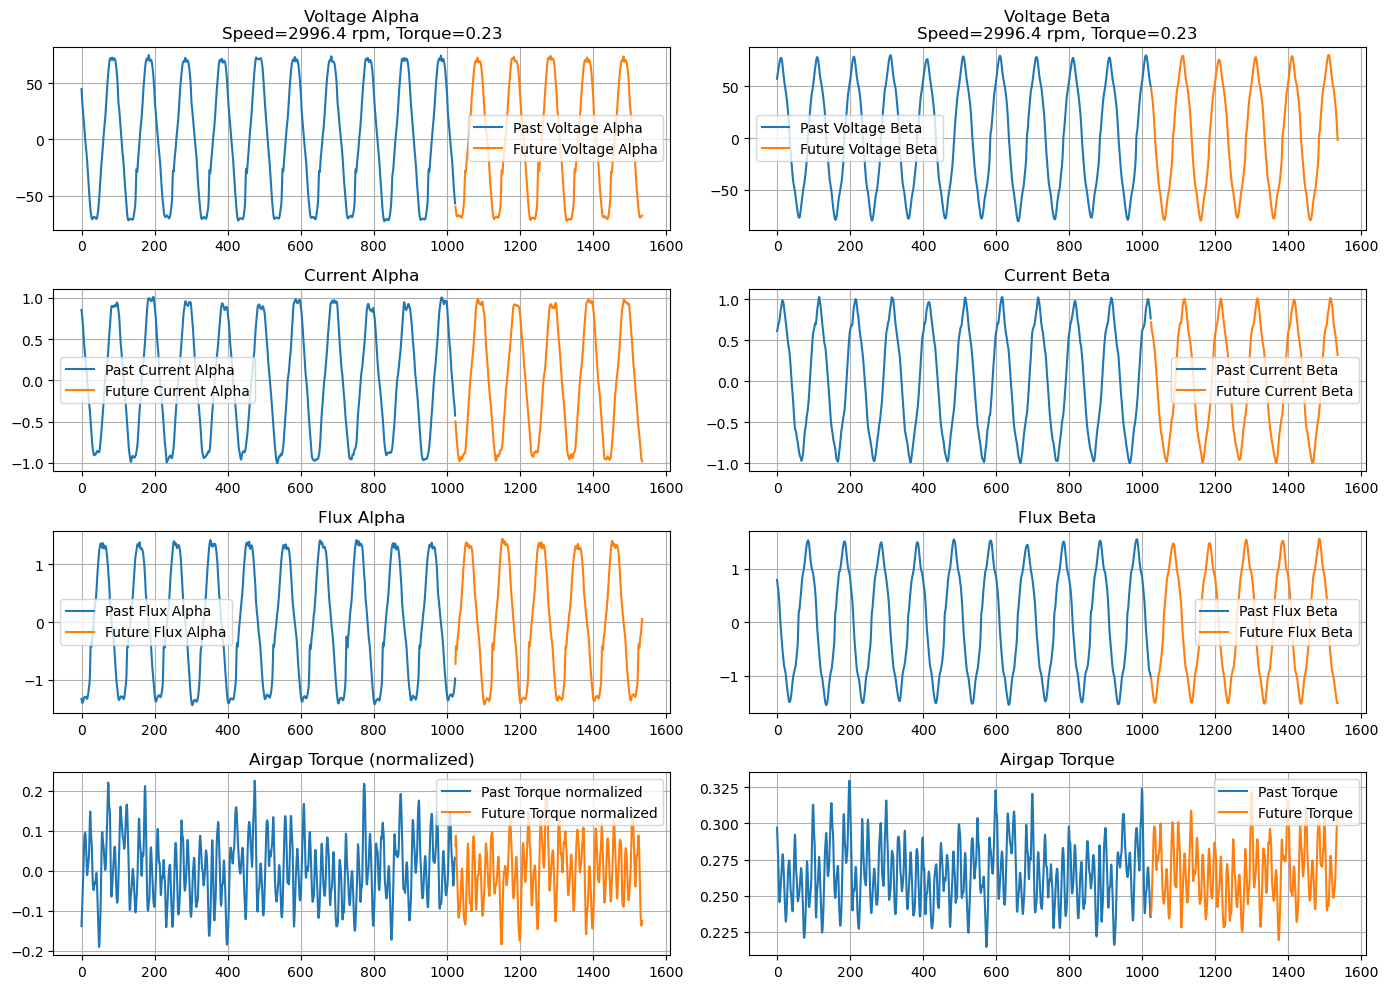

In [5]:
idx = 1  # 可調整索引以觀察不同樣本

def plot_raw_data(idx):
    fig, axs = plt.subplots(4, 2, figsize=(14, 10))
    time_past = np.arange(sequence_length)
    time_future = np.arange(sequence_length, sequence_length + future_length)

    # 取得運轉條件
    speed_val = speed_array_pu[idx, 0] * 3000  # 還原為 rpm
    torque_val = torque_array[idx, 0]

    # 電壓
    axs[0, 0].plot(time_past, past_voltages[idx, :, 0], label='Past Voltage Alpha')
    axs[0, 0].plot(time_future, future_voltages[idx, :, 0], label='Future Voltage Alpha')
    axs[0, 0].set_title(f'Voltage Alpha\nSpeed={speed_val:.1f} rpm, Torque={torque_val:.2f}')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    axs[0, 1].plot(time_past, past_voltages[idx, :, 1], label='Past Voltage Beta')
    axs[0, 1].plot(time_future, future_voltages[idx, :, 1], label='Future Voltage Beta')
    axs[0, 1].set_title(f'Voltage Beta\nSpeed={speed_val:.1f} rpm, Torque={torque_val:.2f}')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # 電流
    axs[1, 0].plot(time_past, past_currents[idx, :, 0], label='Past Current Alpha')
    axs[1, 0].plot(time_future, future_currents[idx, :, 0], label='Future Current Alpha')
    axs[1, 0].set_title('Current Alpha')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    axs[1, 1].plot(time_past, past_currents[idx, :, 1], label='Past Current Beta')
    axs[1, 1].plot(time_future, future_currents[idx, :, 1], label='Future Current Beta')
    axs[1, 1].set_title('Current Beta')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # 磁通
    axs[2, 0].plot(time_past, past_emf_normalized[idx, :, 0], label='Past Flux Alpha')
    axs[2, 0].plot(time_future, future_emf_normalized[idx, :, 0], label='Future Flux Alpha')
    axs[2, 0].set_title('Flux Alpha')
    axs[2, 0].legend()
    axs[2, 0].grid(True)

    axs[2, 1].plot(time_past, past_emf_normalized[idx, :, 1], label='Past Flux Beta')
    axs[2, 1].plot(time_future, future_emf_normalized[idx, :, 1], label='Future Flux Beta')
    axs[2, 1].set_title('Flux Beta')
    axs[2, 1].legend()
    axs[2, 1].grid(True)

    # 力矩
    print(past_airgap_torque_normalized.shape)
    axs[3, 0].plot(time_past, past_airgap_torque_normalized[idx, :,0], label='Past Torque normalized')
    axs[3, 0].plot(time_future, future_airgap_torque_normalized[idx, :,0], label='Future Torque normalized')
    axs[3, 0].set_title('Airgap Torque (normalized)')
    axs[3, 0].legend()
    axs[3, 0].grid(True)

    axs[3, 1].plot(time_past, past_airgap_torque[idx, : ,0], label='Past Torque')
    axs[3, 1].plot(time_future, future_airgap_torque[idx, :,0], label='Future Torque')
    axs[3, 1].set_title('Airgap Torque')
    axs[3, 1].legend()
    axs[3, 1].grid(True)

    plt.tight_layout()
    plt.show()
plot_raw_data(idx)

### 訊練 LSTM 模型 ###

In [6]:
Normal_subfolders

['D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 1200 0.5v  2kg cm2',
 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 1200 1.0v  2kg cm2',
 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 1200 2.0v  2kg cm2',
 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 1800 0.5v  2kg cm2',
 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 1800 1.0v  2kg cm2',
 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 1800 2.0v  2kg cm2',
 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 3000 0.5v  2kg cm2',
 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 3000 1.0v  2kg cm2',
 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 3000 2.0v  2kg cm2']

Vin Iout

1/1 [==============================] - 3s 3s/step
Model structures passed, start training...
Weight: w = 1.0 + spd_weight/(t_weight + eps)
torque : [0.997216   0.93551564 0.9427239  0.56850135 1.000103   0.95421606
 0.35598937 0.35891646 0.38151646 0.378167  ]
speed : [0.39935303 0.9988098  0.99887085 0.598999   0.39959717 0.99645996
 0.59939575 0.59976196 0.9981384  0.99942017]
weight : [1.4000667 2.0665169 2.0584354 2.0517955 1.3991568 2.0431776 2.67903
 2.6663923 3.6094    3.635831 ]
(78000,) 1.398776 3.7247343
開始訓練...
Epoch 1/50
549/549 [==============================] - 20s 29ms/step - loss: 0.0473 - val_loss: 0.0095 - lr: 0.0010
Epoch 2/50
549/549 [==============================] - 14s 26ms/step - loss: 0.0084 - val_loss: 0.0073 - lr: 0.0010
Epoch 3/50
549/549 [==============================] - 14s 25ms/step - loss: 0.0075 - val_loss: 0.0077 - lr: 0.0010
Epoch 4/50
549/549 [==============================] - 14s 26ms/step - loss: 0.0071 - val_loss: 0.0067 - lr: 0.0010
Epoch 5/50
5

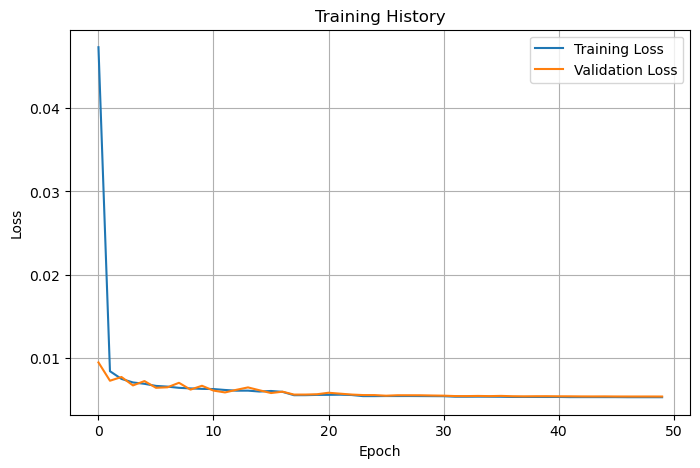

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# gpus = tf.config.experimental.list_physical_devices('GPU')
# print("GPU devices found:")
# for gpu in gpus:
#     print(gpu)
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)
# from tensorflow.python.client import device_lib
# local_devices = device_lib.list_local_devices()
# for device in local_devices:
#     if device.device_type == 'GPU':
#         print("GPU name:", device.physical_device_desc)
        
def combined_time_freq_loss(y_true, y_pred):
    # 時域 MSE
    mse_time = tf.reduce_mean(tf.square(y_true - y_pred))
    # 頻域 MSE（幅值）
    fft_true = tf.signal.rfft(y_true)
    fft_pred = tf.signal.rfft(y_pred)
    mse_freq = tf.reduce_mean(tf.square(tf.abs(fft_true - fft_pred)))
    # 自訂權重，或動態調整
    return 0.7 * mse_time + 0.3 * mse_freq

def compile_and_prepare_model(model, initial_learning_rate=1e-3):
    
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse',
        weighted_metrics=[]
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=1e-6,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

lr_scheduler_flux, early_stop_flux = compile_and_prepare_model(my_model_V_in_I_out)

# 測試模型結構是否正確
my_model_V_in_I_out.predict([ past_emf[0:1,:,:], speed_array_pu[0:1,:], torque_array[0:1,:]])  
#測試模型是否能夠正確讀取
my_model_V_in_I_out.save(os.path.join(model_path, model_name + '_EMF.keras'))
my_model_V_in_I_out= load_model(os.path.join(model_path, model_name + '_EMF.keras'))
print("Model structures passed, start training...")

# 假設 torque_array 形狀為 (num_samples,) 或 (num_samples, 1)
t_weight = np.abs(np.squeeze(torque_array/0.25)).astype(np.float32)
spd_weight = np.abs(np.squeeze(speed_array_pu)).astype(np.float32)

# 方法1：反比權重（小力矩→大權重），並避免除以0與過大權重
eps = 1e-3
# w = 1.0 + spd_weight/(t_weight + eps)
w = 1.0+spd_weight/(t_weight + eps)
print('Weight: w = 1.0 + spd_weight/(t_weight + eps)')

# 可選：把平均權重正規化到 1，避免總體學習率「變相改變」
# w = w / np.mean(w)
print(f'torque : {t_weight[0:10]}')
print(f'speed : {spd_weight[0:10]}')
print(f'weight : {w[0:10]}')
print(w.shape, w.min(), w.max())


# # 開始訓練
with tf.device('/GPU:0'):
    print("開始訓練...")
    history_VI = my_model_V_in_I_out.fit(
        x=[past_voltages_normalized, speed_array_pu, torque_array], 
        y=past_currents_normalized,
        sample_weight=w,    
        batch_size=128,
        epochs=50,
        validation_split=0.1, 
        callbacks=[lr_scheduler_flux, early_stop_flux] 
    )

# history_flux = my_model_emf_in_emf_out.fit(
#     x=[past_emf, speed_array_pu, torque_array], 
#     y=future_emf,
#     batch_size=128,
#     epochs=50,
#     validation_split=0.1, 
#     callbacks=[lr_scheduler_flux, early_stop_flux] 
# )

plt.figure(figsize=(8, 5))
plt.plot(history_VI.history['loss'], label='Training Loss')
if 'val_loss' in history_VI.history:
    plt.plot(history_VI.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

# save model 
my_model_V_in_I_out.save(os.path.join(model_path, model_name + '_VI.keras'))

metadata = {
    "model_name": model_name+'_VI',
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "trained": True,
    "train_loss": history_VI.history['loss'][-1],
    "val_loss": history_VI.history.get('val_loss', [None])[-1],
    "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

with open(os.path.join(model_path, model_name + '_VI_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)


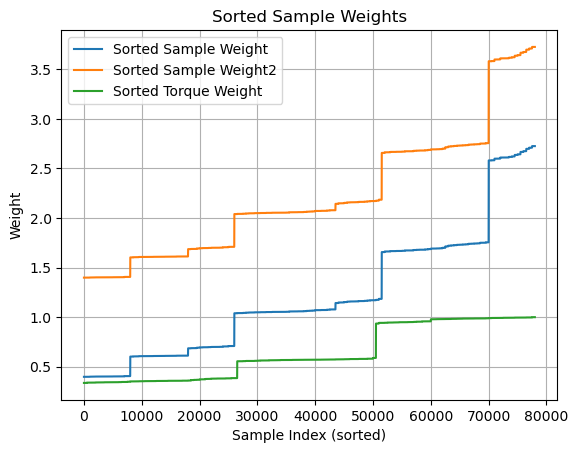

In [8]:
# 假設 torque_array 形狀為 (num_samples,) 或 (num_samples, 1)
t_weight = np.abs(np.squeeze(torque_array/0.25)).astype(np.float32)
spd_weight = np.abs(np.squeeze(speed_array_pu)).astype(np.float32)

# 方法1：反比權重（小力矩→大權重），並避免除以0與過大權重
eps = 1e-3
w = 1*spd_weight/(t_weight + eps)
w = w / np.mean(w)
# 畫出排序後的 WEIGHT
# plt.figure(figsize=(10, 4))

w = 1*spd_weight/(t_weight + eps)
# w = w / np.mean(w)
plt.plot(np.sort(w), label='Sorted Sample Weight')

w = 1+spd_weight/(t_weight + eps)
# w = w / np.mean(w)
plt.plot(np.sort(w), label='Sorted Sample Weight2')
plt.plot(np.sort(t_weight), label='Sorted Torque Weight')
plt.xlabel('Sample Index (sorted)')
plt.ylabel('Weight')
plt.title('Sorted Sample Weights')
plt.grid(True)
plt.legend()
plt.show()

In [9]:

# 驗證資料集
val_subfolders = list_subfolders(validation_folder_path)
validation_datasets = {}
for folder in val_subfolders:
    validation_datasets[folder] = get_apply_files_data(folder)

NameError: name 'list_subfolders' is not defined

In [ ]:
# save model 
my_model_V_in_I_out.save(os.path.join(model_path, model_name + '_VI.keras'))
my_model_V_in_I_out= load_model(os.path.join(model_path, model_name + '_VI.keras'))

def list_subfolders(path):
    """列出指定路徑下的所有子資料夾"""
    return [f.path for f in os.scandir(path) if f.is_dir()]

def get_apply_files_data(Normal_subfolders, return_val=False, test_size=0.5):
    # 重採樣次數
    augmen_sample_number=100
    """取得指定工況資料夾下的所有檔案，並分取出部分作驗證"""
    parquet_files = [os.path.join(Normal_subfolders, f) for f in os.listdir(Normal_subfolders) if f.endswith(".parquet")]
    if len(parquet_files)>1:
        apply_parquet_files, apply_val_files = train_test_split(parquet_files, test_size=test_size)
    else:
        apply_parquet_files = parquet_files
        
    train_signals=[] # vi signals alpha beta
    train_signals_normalized=[]
    torque_array=[]
    speed_array_pu=[]
    for file_path in apply_parquet_files:
        if not os.path.exists(file_path):
            print(f"File {file_path} does not exist.")
            continue
        # 讀取資料
        df = read_rul_data(file_path, force_recompute=True)
        if df["Voltage alpha thd"] > 0.1 or df["Voltage beta thd"] > 0.1 or df is None:
            print(f"File {file_path} has high THD, skipping.")
            continue
        current_alpha= np.array(df["Current alpha downsample"])
        current_beta= np.array(df["Current beta downsample"])
        flux_alpha= np.array(df["Flux alpha"])
        flux_beta= np.array(df["Flux beta"])
        if (flux_alpha.shape[0] != current_alpha.shape[0]):
            print(f"File {file_path} has mismatched flux and current lengths, skipping.")
            print(f"flux_alpha length: {flux_alpha.shape[0]}, current_alpha length: {current_alpha.shape[0]}")
            continue
        torque_airgap=1.5*4*(flux_alpha*current_beta-flux_beta*current_alpha)  # 計算 torque
        emf_alpha= (df["Voltage alpha downsample"] - Rs * current_alpha) / (df["Speed"][0] * P * 2 * np.pi / 60)  # 計算電動勢
        emf_beta= (df["Voltage beta downsample"] - Rs * current_beta) / (df["Speed"][0] * P * 2 * np.pi / 60)
        # 標準化
        torque_airgap_normalized = (torque_airgap - np.mean(torque_airgap)) / np.std(torque_airgap)
          
        torque= (df["Torque avg"]) 
        # print(df)
        speed= (df["Speed"][0])
        
        # 合併測試資料至訓練維度 shape=(,4000,dim)
        temp_train_signals = [np.array(df["Voltage alpha downsample"]), 
                              np.array(df["Voltage beta downsample"]),
                              current_alpha,
                              current_beta,
                              flux_alpha,
                              flux_beta,
                              emf_alpha,
                              emf_beta,
                              torque_airgap]
        
        # 將數據正規化到 [-1, 1] 範圍
        temp_train_signals_normalized = []
        # for signal in temp_train_signals:
        #     min_val = np.min(signal)
        #     max_val = np.max(signal)
        #     # 避免除以零的狀況（max == min）
        #     if max_val == min_val:
        #         normalized = np.zeros_like(signal)
        #     else:
        #         normalized = 2 * (signal - min_val) / (max_val - min_val) - 1
        #     temp_train_signals_normalized.append(normalized)
            
        # 將數據標準化（均值為 0，標準差為 1）
        
        for signal in temp_train_signals:
            mean = np.mean(signal)
            std = np.std(signal)
            # 避免除以零的狀況（std == 0）
            if std == 0:
                standardized = np.zeros_like(signal)
            else:
                standardized = (signal - mean) / std
            temp_train_signals_normalized.append(standardized)
        
        
        temp_train_signals_normalized[-1]= torque_airgap_normalized  # 改成std正規化的 torque_airgap
        
        try:
            temp_train_signals = np.stack(temp_train_signals, axis=1)
            temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
        except ValueError as e:
            print(f"Error stacking signals for file {file_path}: {e}")
            print(f"datalength {len(df['Voltage alpha downsample'])}")
            continue
        temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
        temp_train_signals_normalized_augmented = data_random_augmentation(temp_train_signals_normalized, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
        
        train_signals.append(temp_train_input_signals_augmented)
        train_signals_normalized.append(temp_train_signals_normalized_augmented)
        torque_array.append(np.ones(augmen_sample_number) * torque)
        speed_array_pu.append(np.ones(augmen_sample_number) * speed/3000) # rate 3000 rpm 
    train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
    train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
    torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)
    speed_array_pu = np.concatenate(speed_array_pu, axis=0).astype(np.float32)
    
    # 將資料儲存到字典中
    apply_data = {
        "input_signals": train_signals[:, :sequence_length, :],                         # 取前 sequence_length 個時間步長
        "input_signals_normalized": train_signals_normalized[:, :sequence_length, :],   # 取前 sequence_length 個時間步長
        "fit_signals": train_signals[:, -future_length:, :],                            # 取最後 future_length 個時間步長
        "fit_signals_normalized": train_signals_normalized[:, -future_length:, :],      # 取最後 future_length 個時間步長
        "torque_array": torque_array.reshape(-1, 1),
        "speed_array_pu": speed_array_pu.reshape(-1, 1)  # rate 3000 rpm
    }

    apply_data_val={}
    if return_val:
        train_signals=[] # vi signals alpha beta
        train_signals_normalized=[]
        torque_array=[]
        speed_array_pu=[]
        for file_path in apply_val_files:
            if not os.path.exists(file_path):
                print(f"File {file_path} does not exist.")
                continue
            # 讀取資料
            df = read_rul_data(file_path, force_recompute=True)
            if df["Voltage alpha thd"] > 0.1 or df["Voltage beta thd"] > 0.1 or df is None:
                print(f"File {file_path} has high THD, skipping.")
                continue
            current_alpha= np.array(df["Current alpha downsample"])
            current_beta= np.array(df["Current beta downsample"])
            flux_alpha= np.array(df["Flux alpha"])
            flux_beta= np.array(df["Flux beta"])
            if (flux_alpha.shape[0] != current_alpha.shape[0]):
                print(f"File {file_path} has mismatched flux and current lengths, skipping.")
                print(f"flux_alpha length: {flux_alpha.shape[0]}, current_alpha length: {current_alpha.shape[0]}")
                continue
            torque_airgap=1.5*4*(flux_alpha*current_beta-flux_beta*current_alpha)  # 計算 torque
            emf_alpha= (df["Voltage alpha downsample"] - Rs * current_alpha) / (df["Speed"][0] * P * 2 * np.pi / 60)  # 計算電動勢
            emf_beta= (df["Voltage beta downsample"] - Rs * current_beta) / (df["Speed"][0] * P * 2 * np.pi / 60)
            # 標準化
            torque_airgap_normalized = (torque_airgap - np.mean(torque_airgap)) / np.std(torque_airgap)
            
            torque= (df["Torque avg"]) 
            # print(df)
            speed= (df["Speed"][0])
            
            # 合併測試資料至訓練維度 shape=(,4000,dim)
            temp_train_signals = [np.array(df["Voltage alpha downsample"]), 
                                np.array(df["Voltage beta downsample"]),
                                current_alpha,
                                current_beta,
                                flux_alpha,
                                flux_beta,
                                emf_alpha,
                                emf_beta,
                                torque_airgap]
            
            # 將數據正規化到 [-1, 1] 範圍
            temp_train_signals_normalized = []
            # for signal in temp_train_signals:
            #     min_val = np.min(signal)
            #     max_val = np.max(signal)
            #     # 避免除以零的狀況（max == min）
            #     if max_val == min_val:
            #         normalized = np.zeros_like(signal)
            #     else:
            #         normalized = 2 * (signal - min_val) / (max_val - min_val) - 1
            #     temp_train_signals_normalized.append(normalized)
                
            # 將數據標準化（均值為 0，標準差為 1）
            
            for signal in temp_train_signals:
                mean = np.mean(signal)
                std = np.std(signal)
                # 避免除以零的狀況（std == 0）
                if std == 0:
                    standardized = np.zeros_like(signal)
                else:
                    standardized = (signal - mean) / std
                temp_train_signals_normalized.append(standardized)
            
            
            temp_train_signals_normalized[-1]= torque_airgap_normalized  # 改成std正規化的 torque_airgap
            
            try:
                temp_train_signals = np.stack(temp_train_signals, axis=1)
                temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
            except ValueError as e:
                print(f"Error stacking signals for file {file_path}: {e}")
                print(f"datalength {len(df['Voltage alpha downsample'])}")
                continue
            temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
            temp_train_signals_normalized_augmented = data_random_augmentation(temp_train_signals_normalized, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
            
            train_signals.append(temp_train_input_signals_augmented)
            train_signals_normalized.append(temp_train_signals_normalized_augmented)
            torque_array.append(np.ones(augmen_sample_number) * torque)
            speed_array_pu.append(np.ones(augmen_sample_number) * speed/3000) # rate 3000 rpm 
            
        train_signals_val = np.concatenate(train_signals, axis=0).astype(np.float32)
        train_signals_normalized_val = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
        torque_array_val = np.concatenate(torque_array, axis=0).astype(np.float32)
        speed_array_pu_val = np.concatenate(speed_array_pu, axis=0).astype(np.float32)
        # 將資料儲存到字典中
        apply_data_val = {
            "input_signals": train_signals_val[:, :sequence_length, :],                         # 取前 sequence_length 個時間步長
            "input_signals_normalized": train_signals_normalized_val[:, :sequence_length, :],   # 取前 sequence_length 個時間步長
            "fit_signals": train_signals_val[:, -future_length:, :],                            # 取最後 future_length 個時間步長
            "fit_signals_normalized": train_signals_normalized_val[:, -future_length:, :],      # 取最後 future_length 個時間步長
            "torque_array": torque_array_val.reshape(-1, 1),
            "speed_array_pu": speed_array_pu_val.reshape(-1, 1)  # rate 3000 rpm
        }

        
        
    return apply_data, apply_data_val



# 不同故障重建誤差比對
Consitions=["1200 0.5v", "1200 1.0v", "1200 2.0v",
            "1800 0.5v", "1800 1.0v", "1800 2.0v",
            "3000 0.5v", "3000 1.0v", "3000 2.0v"]

#健康資料集
Normal_subfolders = list_subfolders(os.path.join(NTU_dataset_path, normal_condition))
#建立一個字典來儲存每個資料夾的檔案資料與數據
normal_datasets = {}
validation_datasets={}
for folder in Normal_subfolders:
    normal_datasets[folder], validation_datasets[folder] = get_apply_files_data(folder)

# 驗證資料集
# val_subfolders = list_subfolders(validation_folder_path)
# validation_datasets = {}
# for folder in val_subfolders:
#     validation_datasets[folder] = get_apply_files_data(folder)
    
#對照健康資料集
Normal2_data_path= os.path.join(NTU_dataset_path, 'normal-2')
Normal2_subfolders = list_subfolders(os.path.join(NTU_dataset_path, 'normal-2'))
#建立一個字典來儲存每個資料夾的檔案資料與數據
normal2_datasets = {}
for folder in Normal2_subfolders:
    normal2_datasets[folder], _ = get_apply_files_data(folder)

#異常資料集
Abnormal_data_path = os.path.join(NTU_dataset_path, 'wear-out-2(worse)')
# Abnormal_data_path = os.path.join(NTU_dataset_path, 'drill 2mm 2mm q')
# Abnormal_data_path = os.path.join(NTU_dataset_path, 'cut 2mm')

Abnormal_subfolders = list_subfolders(Abnormal_data_path)    
abnormal_datasets = {}
for folder in Abnormal_subfolders:
    abnormal_datasets[folder], _ = get_apply_files_data(folder)


Abnormal2_data_path = os.path.join(NTU_dataset_path, 'drill 2mm 2mm q')
abnormal2_subfolders = list_subfolders(Abnormal2_data_path)
abnormal2_datasets = {}
for folder in abnormal2_subfolders:
    abnormal2_datasets[folder], _ = get_apply_files_data(folder)

Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalc

In [162]:
def get_apply_files_data(Normal_subfolders, return_val=False, test_size=0.5):
    # 重採樣次數
    augmen_sample_number=100
    """取得指定工況資料夾下的所有檔案，並分取出部分作驗證"""
    parquet_files = [os.path.join(Normal_subfolders, f) for f in os.listdir(Normal_subfolders) if f.endswith(".parquet")]
    if len(parquet_files)>1:
        apply_parquet_files, apply_val_files = train_test_split(parquet_files, test_size=test_size)
    else:
        apply_parquet_files = parquet_files
        
    train_signals=[] # vi signals alpha beta
    train_signals_normalized=[]
    torque_array=[]
    speed_array_pu=[]
    for file_path in apply_parquet_files:
        if not os.path.exists(file_path):
            print(f"File {file_path} does not exist.")
            continue
        # 讀取資料
        df = read_rul_data(file_path, force_recompute=True)
        if df["Voltage alpha thd"] > 0.1 or df["Voltage beta thd"] > 0.1 or df is None:
            print(f"File {file_path} has high THD, skipping.")
            continue
        current_alpha= np.array(df["Current alpha downsample"])
        current_beta= np.array(df["Current beta downsample"])
        flux_alpha= np.array(df["Flux alpha"])
        flux_beta= np.array(df["Flux beta"])
        if (flux_alpha.shape[0] != current_alpha.shape[0]):
            print(f"File {file_path} has mismatched flux and current lengths, skipping.")
            print(f"flux_alpha length: {flux_alpha.shape[0]}, current_alpha length: {current_alpha.shape[0]}")
            continue
        torque_airgap=1.5*4*(flux_alpha*current_beta-flux_beta*current_alpha)  # 計算 torque
        emf_alpha= (df["Voltage alpha downsample"] - Rs * current_alpha) / (df["Speed"][0] * P * 2 * np.pi / 60)  # 計算電動勢
        emf_beta= (df["Voltage beta downsample"] - Rs * current_beta) / (df["Speed"][0] * P * 2 * np.pi / 60)
        # 標準化
        torque_airgap_normalized = (torque_airgap - np.mean(torque_airgap)) / np.std(torque_airgap)
          
        torque= (df["Torque avg"]) 
        # print(df)
        speed= (df["Speed"][0])
        
        # 合併測試資料至訓練維度 shape=(,4000,dim)
        temp_train_signals = [np.array(df["Voltage alpha downsample"]), 
                              np.array(df["Voltage beta downsample"]),
                              current_alpha,
                              current_beta,
                              flux_alpha,
                              flux_beta,
                              emf_alpha,
                              emf_beta,
                              torque_airgap]
        
        # 將數據正規化到 [-1, 1] 範圍
        temp_train_signals_normalized = []
        # for signal in temp_train_signals:
        #     min_val = np.min(signal)
        #     max_val = np.max(signal)
        #     # 避免除以零的狀況（max == min）
        #     if max_val == min_val:
        #         normalized = np.zeros_like(signal)
        #     else:
        #         normalized = 2 * (signal - min_val) / (max_val - min_val) - 1
        #     temp_train_signals_normalized.append(normalized)
            
        # 將數據標準化（均值為 0，標準差為 1）
        
        for signal in temp_train_signals:
            mean = np.mean(signal)
            std = np.std(signal)
            # 避免除以零的狀況（std == 0）
            if std == 0:
                standardized = np.zeros_like(signal)
            else:
                standardized = (signal - mean) / std
            temp_train_signals_normalized.append(standardized)
        
        
        temp_train_signals_normalized[-1]= torque_airgap_normalized  # 改成std正規化的 torque_airgap
        
        try:
            temp_train_signals = np.stack(temp_train_signals, axis=1)
            temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
        except ValueError as e:
            print(f"Error stacking signals for file {file_path}: {e}")
            print(f"datalength {len(df['Voltage alpha downsample'])}")
            continue
        temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
        temp_train_signals_normalized_augmented = data_random_augmentation(temp_train_signals_normalized, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
        
        train_signals.append(temp_train_input_signals_augmented)
        train_signals_normalized.append(temp_train_signals_normalized_augmented)
        torque_array.append(np.ones(augmen_sample_number) * torque)
        speed_array_pu.append(np.ones(augmen_sample_number) * speed/3000) # rate 3000 rpm 
    train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
    train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
    torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)
    speed_array_pu = np.concatenate(speed_array_pu, axis=0).astype(np.float32)
    
    # 將資料儲存到字典中
    apply_data = {
        "input_signals": train_signals[:, :sequence_length, :],                         # 取前 sequence_length 個時間步長
        "input_signals_normalized": train_signals_normalized[:, :sequence_length, :],   # 取前 sequence_length 個時間步長
        "fit_signals": train_signals[:, -future_length:, :],                            # 取最後 future_length 個時間步長
        "fit_signals_normalized": train_signals_normalized[:, -future_length:, :],      # 取最後 future_length 個時間步長
        "torque_array": torque_array.reshape(-1, 1),
        "speed_array_pu": speed_array_pu.reshape(-1, 1)  # rate 3000 rpm
    }

    apply_data_val={}
    if return_val:
        augmen_sample_number=50
        train_signals=[] # vi signals alpha beta
        train_signals_normalized=[]
        torque_array=[]
        speed_array_pu=[]
        for file_path in apply_val_files:
            if not os.path.exists(file_path):
                print(f"File {file_path} does not exist.")
                continue
            # 讀取資料
            df = read_rul_data(file_path, force_recompute=True)
            if df["Voltage alpha thd"] > 0.1 or df["Voltage beta thd"] > 0.1 or df is None:
                print(f"File {file_path} has high THD, skipping.")
                continue
            current_alpha= np.array(df["Current alpha downsample"])
            current_beta= np.array(df["Current beta downsample"])
            flux_alpha= np.array(df["Flux alpha"])
            flux_beta= np.array(df["Flux beta"])
            if (flux_alpha.shape[0] != current_alpha.shape[0]):
                print(f"File {file_path} has mismatched flux and current lengths, skipping.")
                print(f"flux_alpha length: {flux_alpha.shape[0]}, current_alpha length: {current_alpha.shape[0]}")
                continue
            torque_airgap=1.5*4*(flux_alpha*current_beta-flux_beta*current_alpha)  # 計算 torque
            emf_alpha= (df["Voltage alpha downsample"] - Rs * current_alpha) / (df["Speed"][0] * P * 2 * np.pi / 60)  # 計算電動勢
            emf_beta= (df["Voltage beta downsample"] - Rs * current_beta) / (df["Speed"][0] * P * 2 * np.pi / 60)
            # 標準化
            torque_airgap_normalized = (torque_airgap - np.mean(torque_airgap)) / np.std(torque_airgap)
            
            torque= (df["Torque avg"]) 
            # print(df)
            speed= (df["Speed"][0])
            
            # 合併測試資料至訓練維度 shape=(,4000,dim)
            temp_train_signals = [np.array(df["Voltage alpha downsample"]), 
                                np.array(df["Voltage beta downsample"]),
                                current_alpha,
                                current_beta,
                                flux_alpha,
                                flux_beta,
                                emf_alpha,
                                emf_beta,
                                torque_airgap]
            
            # 將數據正規化到 [-1, 1] 範圍
            temp_train_signals_normalized = []
            # for signal in temp_train_signals:
            #     min_val = np.min(signal)
            #     max_val = np.max(signal)
            #     # 避免除以零的狀況（max == min）
            #     if max_val == min_val:
            #         normalized = np.zeros_like(signal)
            #     else:
            #         normalized = 2 * (signal - min_val) / (max_val - min_val) - 1
            #     temp_train_signals_normalized.append(normalized)
                
            # 將數據標準化（均值為 0，標準差為 1）
            
            for signal in temp_train_signals:
                mean = np.mean(signal)
                std = np.std(signal)
                # 避免除以零的狀況（std == 0）
                if std == 0:
                    standardized = np.zeros_like(signal)
                else:
                    standardized = (signal - mean) / std
                temp_train_signals_normalized.append(standardized)
            
            
            temp_train_signals_normalized[-1]= torque_airgap_normalized  # 改成std正規化的 torque_airgap
            
            try:
                temp_train_signals = np.stack(temp_train_signals, axis=1)
                temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
            except ValueError as e:
                print(f"Error stacking signals for file {file_path}: {e}")
                print(f"datalength {len(df['Voltage alpha downsample'])}")
                continue
            temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
            temp_train_signals_normalized_augmented = data_random_augmentation(temp_train_signals_normalized, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)

            train_signals.append(temp_train_input_signals_augmented)
            train_signals_normalized.append(temp_train_signals_normalized_augmented)
            torque_array.append(np.ones(augmen_sample_number) * torque)
            speed_array_pu.append(np.ones(augmen_sample_number) * speed/3000) # rate 3000 rpm 
            
        train_signals_val = np.concatenate(train_signals, axis=0).astype(np.float32)
        train_signals_normalized_val = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
        torque_array_val = np.concatenate(torque_array, axis=0).astype(np.float32)
        speed_array_pu_val = np.concatenate(speed_array_pu, axis=0).astype(np.float32)
        # 將資料儲存到字典中
        apply_data_val = {
            "input_signals": train_signals_val[:, :sequence_length, :],                         # 取前 sequence_length 個時間步長
            "input_signals_normalized": train_signals_normalized_val[:, :sequence_length, :],   # 取前 sequence_length 個時間步長
            "fit_signals": train_signals_val[:, -future_length:, :],                            # 取最後 future_length 個時間步長
            "fit_signals_normalized": train_signals_normalized_val[:, -future_length:, :],      # 取最後 future_length 個時間步長
            "torque_array": torque_array_val.reshape(-1, 1),
            "speed_array_pu": speed_array_pu_val.reshape(-1, 1)  # rate 3000 rpm
        }

        
        
    return apply_data, apply_data_val

#健康資料集
Normal_subfolders = list_subfolders(os.path.join(NTU_dataset_path, normal_condition))
#建立一個字典來儲存每個資料夾的檔案資料與數據
normal_datasets = {}
validation_datasets={}
for folder in Normal_subfolders:
    normal_datasets[folder], validation_datasets[folder] = get_apply_files_data(folder, return_val=True)

Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalc

In [ ]:
# normal2_reconstruction_errors_VI  = get_mse_from_folder(normal2_datasets, Normal2_subfolders, my_model_V_in_I_out)
val_reconstruction_errors_VI  = get_mse_from_folder(validation_datasets, Normal_subfolders, my_model_V_in_I_out)
# validation_datasets

ValueError: Data cardinality is ambiguous:
  x sizes: 550, 1100, 1100
Make sure all arrays contain the same number of samples.

### 確認離群值 ###

In [ ]:

def list_model_MSEs(Normal_subfolders, model, test_size=0.5):
    # 列出目標資料夾下的檔案重建誤差以找出離群值
    augmen_sample_number=100
    """取得指定工況資料夾下的所有檔案，並找出離群值"""
    parquet_files = [os.path.join(Normal_subfolders, f) for f in os.listdir(Normal_subfolders) if f.endswith(".parquet")]
    if len(parquet_files)>1:
        apply_parquet_files, _ = train_test_split(parquet_files, test_size=test_size)
    else:
        apply_parquet_files = parquet_files


    for file_path in apply_parquet_files:
        train_signals=[] # vi signals alpha beta
        train_signals_normalized=[]
        torque_array=[]
        speed_array_pu=[]
        if not os.path.exists(file_path):
            print(f"File {file_path} does not exist.")
            continue
        # 讀取資料
        df = read_rul_data(file_path, force_recompute=True)
        if df["Voltage alpha thd"] > 0.1 or df["Voltage beta thd"] > 0.1 or df is None:
            print(f"File {file_path} has high THD, skipping.")
            continue
        current_alpha= np.array(df["Current alpha downsample"])
        current_beta= np.array(df["Current beta downsample"])
        flux_alpha= np.array(df["Flux alpha"])
        flux_beta= np.array(df["Flux beta"])
        if (flux_alpha.shape[0] != current_alpha.shape[0]):
            print(f"File {file_path} has mismatched flux and current lengths, skipping.")
            print(f"flux_alpha length: {flux_alpha.shape[0]}, current_alpha length: {current_alpha.shape[0]}")
            continue
        torque_airgap=1.5*4*(flux_alpha*current_beta-flux_beta*current_alpha)  # 計算 torque
        emf_alpha= (df["Voltage alpha downsample"] - Rs * current_alpha) / (df["Speed"][0] * P * 2 * np.pi / 60)  # 計算電動勢
        emf_beta= (df["Voltage beta downsample"] - Rs * current_beta) / (df["Speed"][0] * P * 2 * np.pi / 60)
        # 標準化
        torque_airgap_normalized = (torque_airgap - np.mean(torque_airgap)) / np.std(torque_airgap)
          
        torque= (df["Torque avg"]) 
        # print(df)
        speed= (df["Speed"][0])
        
        # 合併測試資料至訓練維度 shape=(,4000,dim)
        temp_train_signals = [np.array(df["Voltage alpha downsample"]), 
                              np.array(df["Voltage beta downsample"]),
                              current_alpha,
                              current_beta,
                              flux_alpha,
                              flux_beta,
                              emf_alpha,
                              emf_beta,
                              torque_airgap]
        
        # 將數據正規化到 [-1, 1] 範圍
        temp_train_signals_normalized = []
        # for signal in temp_train_signals:
        #     min_val = np.min(signal)
        #     max_val = np.max(signal)
        #     # 避免除以零的狀況（max == min）
        #     if max_val == min_val:
        #         normalized = np.zeros_like(signal)
        #     else:
        #         normalized = 2 * (signal - min_val) / (max_val - min_val) - 1
        #     temp_train_signals_normalized.append(normalized)
            
        # 將數據標準化（均值為 0，標準差為 1）
        
        for signal in temp_train_signals:
            mean = np.mean(signal)
            std = np.std(signal)
            # 避免除以零的狀況（std == 0）
            if std == 0:
                standardized = np.zeros_like(signal)
            else:
                standardized = (signal - mean) / std
            temp_train_signals_normalized.append(standardized)
        
        
        temp_train_signals_normalized[-1]= torque_airgap_normalized  # 改成std正規化的 torque_airgap
        
        try:
            temp_train_signals = np.stack(temp_train_signals, axis=1)
            temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
        except ValueError as e:
            print(f"Error stacking signals for file {file_path}: {e}")
            print(f"datalength {len(df['Voltage alpha downsample'])}")
            continue
        
        temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, 1024, augmen_sample_number=100,future_length=512)
        temp_train_signals_normalized_augmented = data_random_augmentation(temp_train_signals_normalized, 1024, augmen_sample_number=100,future_length=512)
        train_signals.append(temp_train_input_signals_augmented)
        train_signals_normalized.append(temp_train_signals_normalized_augmented)
        torque_array.append(np.ones(augmen_sample_number) * torque)
        speed_array_pu.append(np.ones(augmen_sample_number) * speed/3000) # rate 3000 rpm 
        
        train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
        train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
        torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)
        speed_array_pu = np.concatenate(speed_array_pu, axis=0).astype(np.float32)
        
        apply_input_data = train_signals_normalized[:, :sequence_length, 0:2]  # 過去 emf
        apply_output_data = train_signals_normalized[:, :sequence_length, 2:4]  # 過去 current（僅用於比較/誤差）
        check_reconstruction_normal = model.predict(
            [apply_input_data,
            speed_array_pu.reshape(-1, 1),
            torque_array.reshape(-1, 1)],
            batch_size=128,
            verbose=0
        )

        error = apply_output_data[:, :, 0] - check_reconstruction_normal[:, :, 0]
        error_mse = np.mean(np.square(error),axis=1)  # 計算每個樣本的 MSE
        print(error_mse.mean(), end='')
        print(file_path)

    return error_mse


list_model_MSEs(r"D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1800 1.0v  2kg cm2", my_model_V_in_I_out, test_size=1)

#健康資料集
Normal_subfolders = list_subfolders(os.path.join(NTU_dataset_path, normal_condition))
#建立一個字典來儲存每個資料夾的檔案資料與數據
normal_datasets = {}
for folder in Normal_subfolders:
    normal_datasets[folder],_ = get_apply_files_data(folder)


Missing keys in the parquet file, recalculating and saving:
0.001330746D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1800 1.0v  2kg cm2\RUL_Data_3_9.parquet
Missing keys in the parquet file, recalculating and saving:
0.0012793933D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1800 1.0v  2kg cm2\RUL_Data_3_3.parquet
Missing keys in the parquet file, recalculating and saving:
0.0010397739D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1800 1.0v  2kg cm2\RUL_Data_3_10.parquet
Missing keys in the parquet file, recalculating and saving:
0.00081136246D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1800 1.0v  2kg cm2\RUL_Data_3_1.parquet
Missing keys in the parquet file, recalculating and saving:
0.0013716355D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1800 1.0v  2kg cm2\RUL_Data_3_11.parquet
Missing keys in the parquet file, recalculating and saving:
0.0017369112D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\nor

In [12]:
# 計算高斯分布參數
def Guassian_2D_MLE(x, y):
   data = np.stack((x, y), axis=1)
   mean_vector = np.mean(data, axis=0)
   cov_matrix = np.cov(data, rowvar=False)
   return mean_vector, cov_matrix

def Bhattacharyya_distnace_2D(mean_vector1, cov_matrix1, mean_vector2, cov_matrix2):
    # 計算 Bhattacharyya 距離
    
    cov_avg = (cov_matrix1 + cov_matrix2) / 2
    term1 = 0.5 * np.log(np.linalg.det(cov_avg) / np.sqrt(np.linalg.det(cov_matrix1) * np.linalg.det(cov_matrix2)))
    term2 = 0.125 * (mean_vector2 - mean_vector1).T @ np.linalg.inv(cov_avg) @ (mean_vector2 - mean_vector1)
    return term1 + term2

10/10 [==============================] - 0s 21ms/step


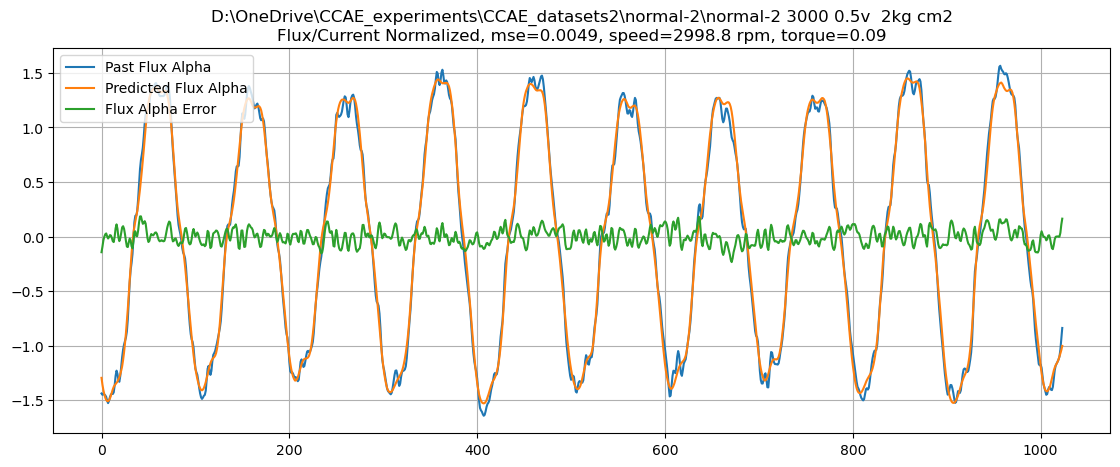

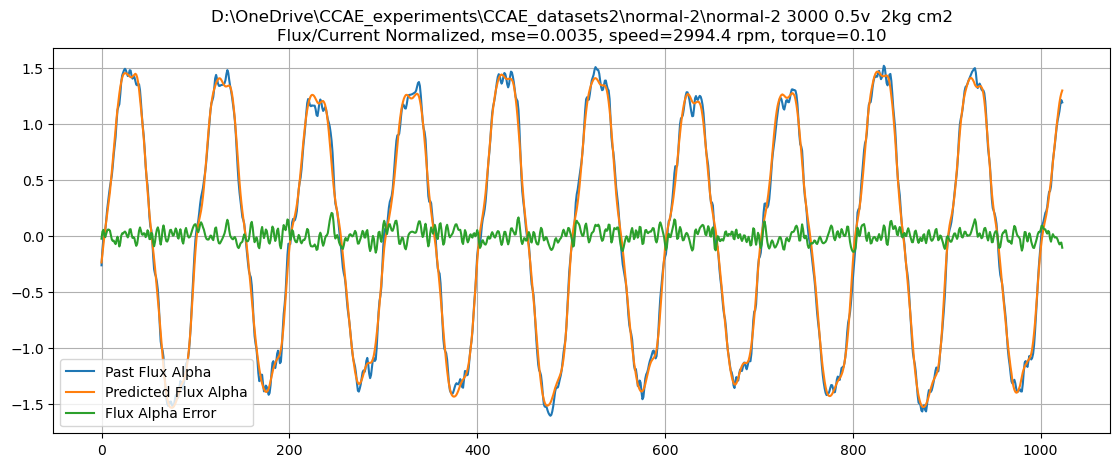

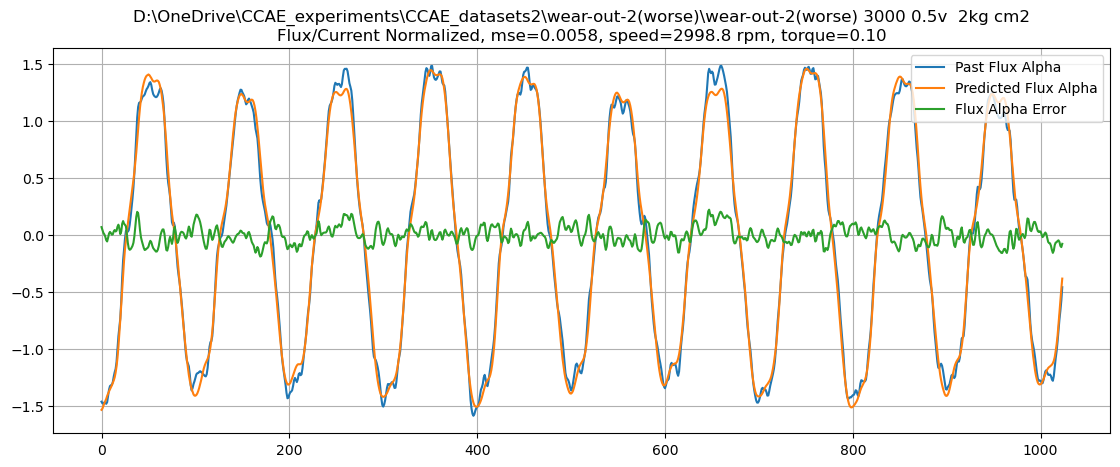

In [13]:
# --- 參數 ---
condition_number = 6   # 保持你原本的設定
idx = 0                # 用來在標題顯示第 idx 筆的速度/扭矩；若已有外部 idx 可刪除這行

# --- Normal ---
check_past_emf_normal = normal_datasets[Normal_subfolders[condition_number]]["input_signals_normalized"][:, :, 0:2]  # 過去 emf
check_past_current_normal = normal_datasets[Normal_subfolders[condition_number]]["input_signals_normalized"][:, :, 2:4]  # 過去 current（僅用於比較/誤差）
check_reconstruction_normal = my_model_V_in_I_out.predict(
    [check_past_emf_normal,
     normal_datasets[Normal_subfolders[condition_number]]["speed_array_pu"],
     normal_datasets[Normal_subfolders[condition_number]]["torque_array"]],
    batch_size=128
)

# --- Normal2（新增） ---
check_past_emf_normal2 = normal2_datasets[Normal2_subfolders[condition_number]]["input_signals_normalized"][:, :, 0:2]
check_past_current_normal2 = normal2_datasets[Normal2_subfolders[condition_number]]["input_signals_normalized"][:, :, 2:4]
check_reconstruction_normal2 = my_model_V_in_I_out.predict(
    [check_past_emf_normal2,
     normal2_datasets[Normal2_subfolders[condition_number]]["speed_array_pu"],
     normal2_datasets[Normal2_subfolders[condition_number]]["torque_array"]],
    batch_size=128
)

# --- Abnormal ---
check_past_emf_abnormal = abnormal_datasets[Abnormal_subfolders[condition_number]]["input_signals_normalized"][:, :, 0:2]
check_past_current_abnormal = abnormal_datasets[Abnormal_subfolders[condition_number]]["input_signals_normalized"][:, :, 2:4]
check_reconstruction_abnormal = my_model_V_in_I_out.predict(
    [check_past_emf_abnormal,
     abnormal_datasets[Abnormal_subfolders[condition_number]]["speed_array_pu"],
     abnormal_datasets[Abnormal_subfolders[condition_number]]["torque_array"]],
    batch_size=128
)

# --- Plot: NORMAL ---
plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.plot(range(sequence_length), check_past_current_normal[idx, :, 0], label='Past Flux Alpha')
plt.plot(range(sequence_length), check_reconstruction_normal[idx, :, 0], label='Predicted Flux Alpha')
error = check_past_current_normal[idx, :, 0] - check_reconstruction_normal[idx, :, 0]
plt.plot(range(sequence_length), error, label='Flux Alpha Error')
plt.title(
    f'{Normal_subfolders[condition_number]}\n'
    f'Flux/Current Normalized, mse={np.mean(np.square(error)):.4f}, '
    f'speed={normal_datasets[Normal_subfolders[condition_number]]["speed_array_pu"][idx, 0]*3000:.1f} rpm, '
    f'torque={normal_datasets[Normal_subfolders[condition_number]]["torque_array"][idx, 0]:.2f}'
)
plt.legend()
plt.grid(True)

# --- Plot: NORMAL2 ---
plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.plot(range(sequence_length), check_past_current_normal2[idx, :, 0], label='Past Flux Alpha')
plt.plot(range(sequence_length), check_reconstruction_normal2[idx, :, 0], label='Predicted Flux Alpha')
error = check_past_current_normal2[idx, :, 0] - check_reconstruction_normal2[idx, :, 0]
plt.plot(range(sequence_length), error, label='Flux Alpha Error')
plt.title(
    f'{Normal2_subfolders[condition_number]}\n'
    f'Flux/Current Normalized, mse={np.mean(np.square(error)):.4f}, '
    f'speed={normal2_datasets[Normal2_subfolders[condition_number]]["speed_array_pu"][idx, 0]*3000:.1f} rpm, '
    f'torque={normal2_datasets[Normal2_subfolders[condition_number]]["torque_array"][idx, 0]:.2f}'
)
plt.legend()
plt.grid(True)

# --- Plot: ABNORMAL ---
plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.plot(range(sequence_length), check_past_current_abnormal[idx, :, 0], label='Past Flux Alpha')
plt.plot(range(sequence_length), check_reconstruction_abnormal[idx, :, 0], label='Predicted Flux Alpha')
error = check_past_current_abnormal[idx, :, 0] - check_reconstruction_abnormal[idx, :, 0]
plt.plot(range(sequence_length), error, label='Flux Alpha Error')
plt.title(
    f'{Abnormal_subfolders[condition_number]}\n'
    f'Flux/Current Normalized, mse={np.mean(np.square(error)):.4f}, '
    f'speed={abnormal_datasets[Abnormal_subfolders[condition_number]]["speed_array_pu"][idx, 0]*3000:.1f} rpm, '
    f'torque={abnormal_datasets[Abnormal_subfolders[condition_number]]["torque_array"][idx, 0]:.2f}'
)
plt.legend()
plt.grid(True)


Condition: 1200 0.5v, Normal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 0.5v  2kg cm2, Normal2 Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 0.5v  2kg cm2, Val Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 0.5v  2kg cm2, Abnormal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\wear-out-2(worse)\wear-out-2(worse) 1200 0.5v  2kg cm2, Abnormal2 Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\drill 2mm 2mm q\drill 2mm 2mm q 1200 0.5v 2kg cm2
Condition: 1200 1.0v, Normal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 1.0v  2kg cm2, Normal2 Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 1.0v  2kg cm2, Val Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 1.0v  2kg cm2, Abnormal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\wear-out-2(worse)\wear-out-2(worse) 1200 1.0v  2kg cm2, Abnormal2 Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\

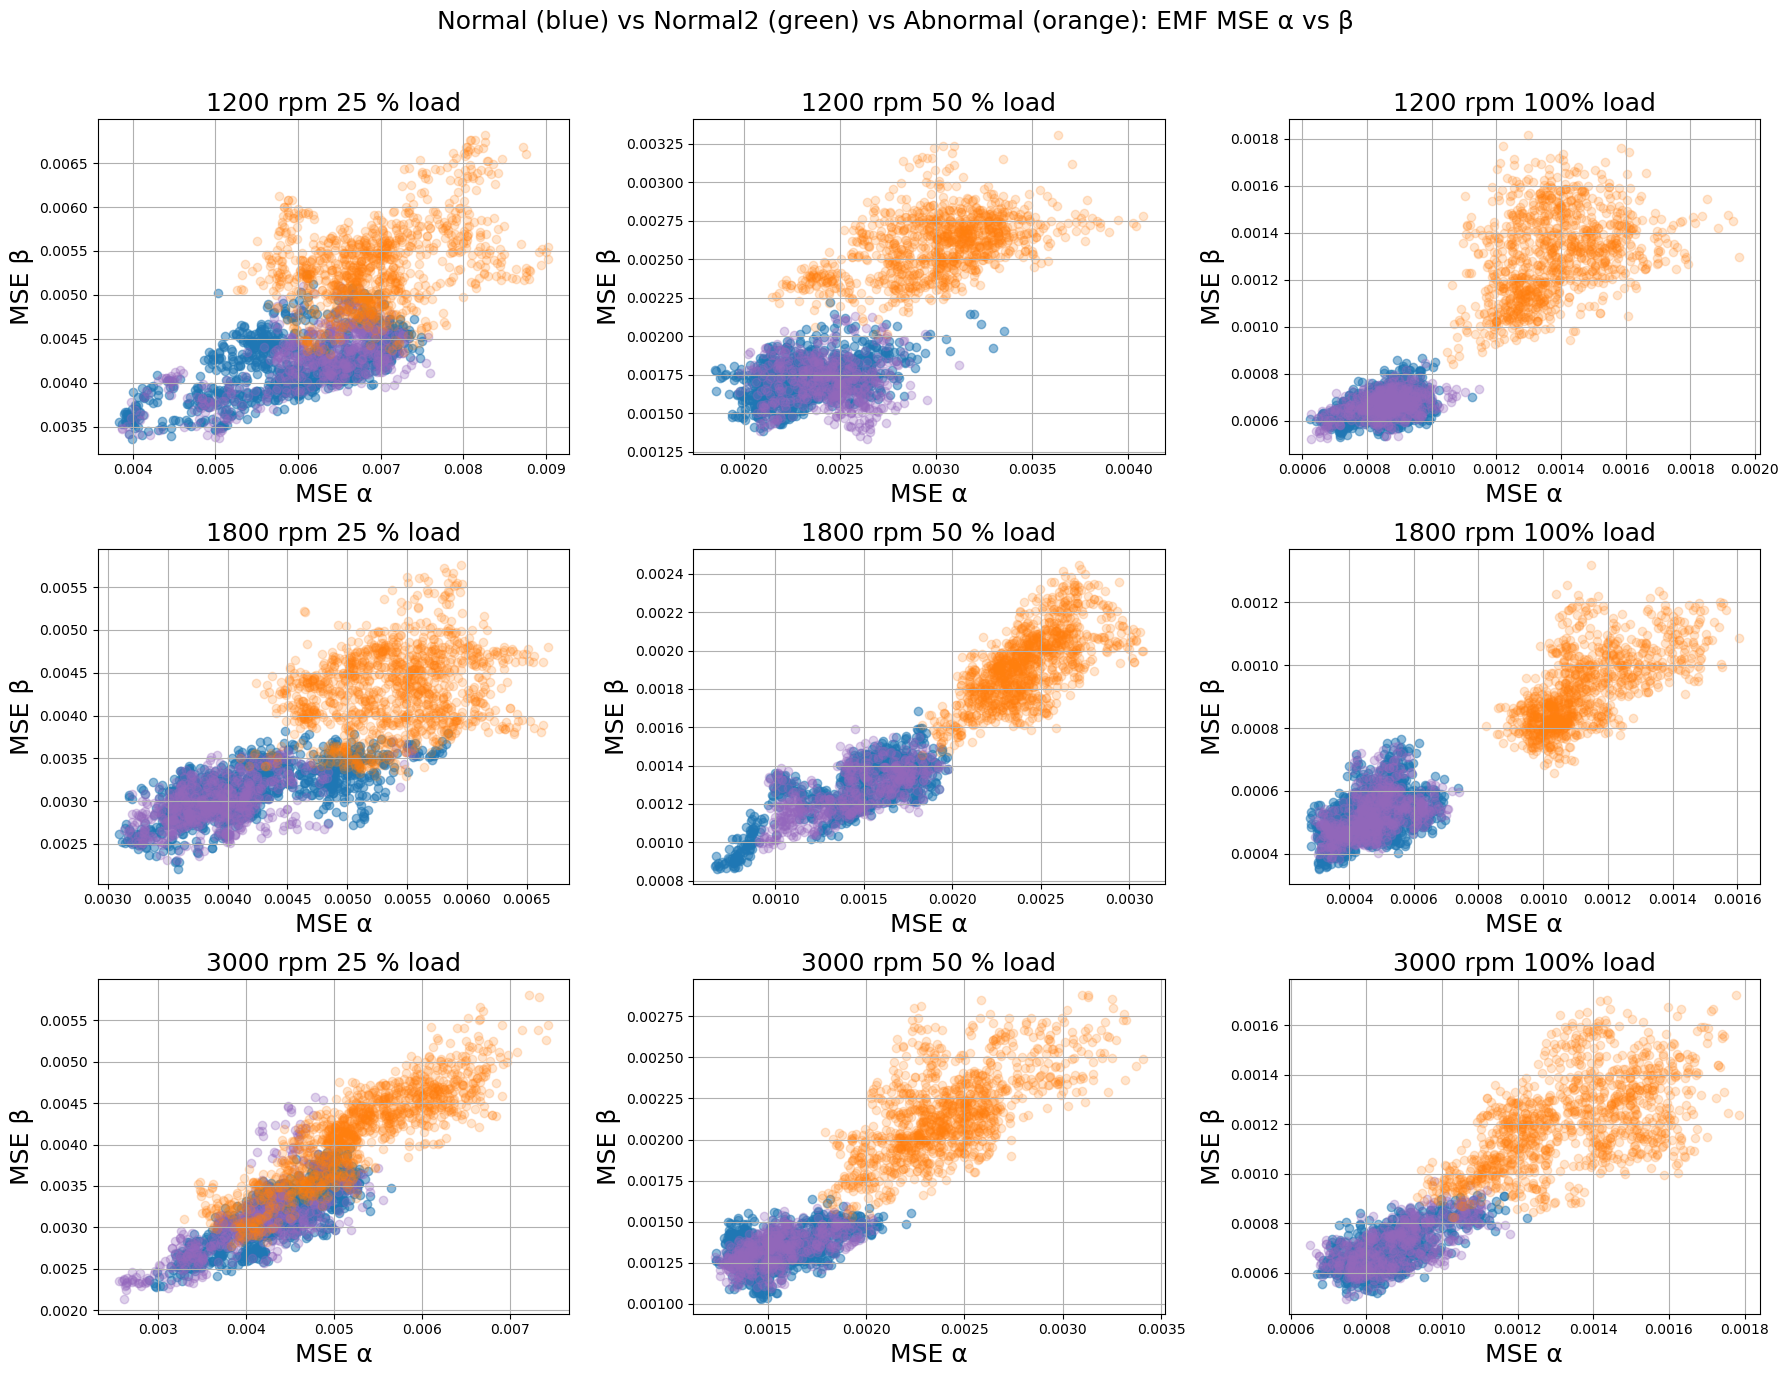

In [189]:

#計算重建MSE資料
def get_mse_from_folder(datasets, folders, model, batch_size=128):
    """
    計算指定資料集中每個子資料夾的重建 MSE
    
    Args:
        datasets (dict): 包含 input_signals_normalized, speed_array_pu, torque_array 的資料集
        folders (list): 子資料夾名稱列表
        model (keras.Model): 用來預測的模型
        batch_size (int): 批次大小，預設 128
    
    Returns:
        dict: 每個 folder 對應的 MSE 結果
    """
    reconstruction_errors = {}
    
    for folder in folders:
        past_voltage_normalized = datasets[folder]["input_signals_normalized"][:, :, 0:2]
        future_current_normalized = datasets[folder]["input_signals_normalized"][:, :, 2:4]
        
        reconstruction_predictions = model.predict(
            [past_voltage_normalized, 
             datasets[folder]["speed_array_pu"], 
             datasets[folder]["torque_array"]],
            batch_size=batch_size,
            verbose=0
        )
        
        mse_alpha = np.mean(
            (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
            axis=1
        )
        mse_beta = np.mean(
            (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
            axis=1
        )
        
        reconstruction_errors[folder] = {
            "EMF_alpha_MSE": mse_alpha,
            "EMF_beta_MSE": mse_beta
        }
    
    return reconstruction_errors

normal_reconstruction_errors_VI   = get_mse_from_folder(normal_datasets, Normal_subfolders, my_model_V_in_I_out)
normal2_reconstruction_errors_VI  = get_mse_from_folder(normal2_datasets, Normal2_subfolders, my_model_V_in_I_out)
val_reconstruction_errors_VI      = get_mse_from_folder(validation_datasets, Normal_subfolders, my_model_V_in_I_out)
abnormal_reconstruction_errors_VI = get_mse_from_folder(abnormal_datasets, Abnormal_subfolders, my_model_V_in_I_out)
abnormal2_reconstruction_errors_VI = get_mse_from_folder(abnormal2_datasets, abnormal2_subfolders, my_model_V_in_I_out)

# 畫出兩者間的分布圖
# Step 0: 定義 Condition Map
Condition_map = {
    '1200 0.5v': 'Condition 1',
    '1200 1.0v': 'Condition 2',
    '1200 2.0v': 'Condition 3',
    '1800 0.5v': 'Condition 4',
    '1800 1.0v': 'Condition 5',
    '1800 2.0v': 'Condition 6',
    '3000 0.5v': 'Condition 7',
    '3000 1.0v': 'Condition 8',
    '3000 2.0v': 'Condition 9',
}

Condition_map_spd_torque = {
    '1200 0.5v': '1200 rpm 25 % load',
    '1200 1.0v': '1200 rpm 50 % load',
    '1200 2.0v': '1200 rpm 100% load',
    '1800 0.5v': '1800 rpm 25 % load',
    '1800 1.0v': '1800 rpm 50 % load',
    '1800 2.0v': '1800 rpm 100% load',
    '3000 0.5v': '3000 rpm 25 % load',
    '3000 1.0v': '3000 rpm 50 % load',
    '3000 2.0v': '3000 rpm 100% load',
}

# print(abnormal_reconstruction_errors_VI.items())


# Step 1: 遍歷 Condition_map，確保三種資料都有對應 key
matched_conditions = []
for cond_key in Condition_map:
    normal_key  = next((k for k in normal_reconstruction_errors_VI  if cond_key in k), None)
    normal2_key = next((k for k in normal2_reconstruction_errors_VI if cond_key in k), None)
    val_key = next((k for k in val_reconstruction_errors_VI if cond_key in k), None)
    abnormal_key = next((k for k in abnormal_reconstruction_errors_VI if cond_key in k), None)
    abnormal2_key = next((k for k in abnormal2_reconstruction_errors_VI if cond_key in k), None)

    print(f"Condition: {cond_key}, Normal Key: {normal_key}, Normal2 Key: {normal2_key}, Val Key: {val_key}, Abnormal Key: {abnormal_key}, Abnormal2 Key: {abnormal2_key}")

    if normal_key and normal2_key and val_key and abnormal_key and abnormal2_key:
        matched_conditions.append((cond_key, normal_key, normal2_key, val_key, abnormal_key, abnormal2_key))

# Step 2: 畫圖（散點圖）
num_folders = len(matched_conditions)
num_figs = int(np.ceil(num_folders / 9))

# BD results 
BD_abnromal_VI = {}
BD_abnormal2_VI = {}
BD_normal2_VI = {}

for fig_idx in range(num_figs):
    fig, axes = plt.subplots(3, 3, figsize=(18, 14))
    fig.suptitle("Normal (blue) vs Normal2 (green) vs Abnormal (orange): EMF MSE α vs β", fontsize=18)

    for i in range(9):
        cond_idx = fig_idx * 9 + i
        if cond_idx >= num_folders:
            axes.flat[i].set_visible(False)
            continue

        cond_key, normal_key, normal2_key, val_key, abnormal_key, abnormal2_key = matched_conditions[cond_idx]
        ax = axes.flat[i]

        # Normal
        x_normal = normal_reconstruction_errors_VI[normal_key]["EMF_alpha_MSE"]
        y_normal = normal_reconstruction_errors_VI[normal_key]["EMF_beta_MSE"]

        # Normal2
        x_normal2 = normal2_reconstruction_errors_VI[normal2_key]["EMF_alpha_MSE"]
        y_normal2 = normal2_reconstruction_errors_VI[normal2_key]["EMF_beta_MSE"]
        
        # validation
        x_val = val_reconstruction_errors_VI[val_key]["EMF_alpha_MSE"]
        y_val = val_reconstruction_errors_VI[val_key]["EMF_beta_MSE"]

        x_abnormal2 = abnormal2_reconstruction_errors_VI[abnormal2_key]["EMF_alpha_MSE"]
        y_abnormal2 = abnormal2_reconstruction_errors_VI[abnormal2_key]["EMF_beta_MSE"]

        # Abnormal
        x_abnormal = abnormal_reconstruction_errors_VI[abnormal_key]["EMF_alpha_MSE"]
        y_abnormal = abnormal_reconstruction_errors_VI[abnormal_key]["EMF_beta_MSE"]
        
        BD_abnormal=Bhattacharyya_distnace_2D(
            Guassian_2D_MLE(x_normal, y_normal)[0],
            Guassian_2D_MLE(x_normal, y_normal)[1],
            Guassian_2D_MLE(x_abnormal, y_abnormal)[0],
            Guassian_2D_MLE(x_abnormal, y_abnormal)[1]
        )
        BD_normal2= Bhattacharyya_distnace_2D(
            Guassian_2D_MLE(x_normal, y_normal)[0],
            Guassian_2D_MLE(x_normal, y_normal)[1],
            Guassian_2D_MLE(x_normal2, y_normal2)[0],
            Guassian_2D_MLE(x_normal2, y_normal2)[1]
        )
        BD_abnormal2 = Bhattacharyya_distnace_2D(
            Guassian_2D_MLE(x_normal, y_normal)[0],
            Guassian_2D_MLE(x_normal, y_normal)[1],
            Guassian_2D_MLE(x_abnormal2, y_abnormal2)[0],
            Guassian_2D_MLE(x_abnormal2, y_abnormal2)[1]
        )

        # 計算BD
        BD_abnromal_VI[f"Condition {i}" ] =BD_abnormal
        BD_abnormal2_VI[f"Condition {i}"] = BD_abnormal2
        BD_normal2_VI[f"Condition {i}"] =BD_normal2
        # 畫散點
        
        ax.scatter(x_normal,  y_normal,  label="Normal",  color='tab:blue',  alpha=0.5)
        ax.scatter(x_val, y_val, label="Validation", color='tab:purple', alpha=0.3)
        # ax.scatter(x_normal2, y_normal2, label=f"Normal2 {BD_normal2:.4f}", color='tab:green', alpha=0.2)
        # ax.scatter(x_abnormal2, y_abnormal2, label=f"Abnormal2 {BD_abnormal2:.4f}", color='tab:cyan', alpha=0.2)
        ax.scatter(x_abnormal,y_abnormal,label=f"Abnormal {BD_abnormal:.4f}",color='tab:orange',alpha=0.2)
        
        
        ax.set_xlabel("MSE α", fontsize=18)
        ax.set_ylabel("MSE β", fontsize=18)
        # ax.legend(loc="best", prop={"family": "Times New Roman", "size": 14})
        ax.set_title(Condition_map_spd_torque[cond_key], fontsize=18)
        ax.grid(True)
        # ax.legend(loc="best")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### 3. 電流 in 電流 out ###
訓練

GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1/1 [==============================] - 0s 288ms/step
Model structures passed, start training...
Epoch 1/50
275/275 [==============================] - 13s 38ms/step - loss: 0.0328 - val_loss: 0.0046 - lr: 0.0010
Epoch 2/50
275/275 [==============================] - 10s 36ms/step - loss: 0.0038 - val_loss: 0.0033 - lr: 0.0010
Epoch 3/50
275/275 [==============================] - 10s 36ms/step - loss: 0.0033 - val_loss: 0.0030 - lr: 0.0010
Epoch 4/50
275/275 [==============================] - 10s 36ms/step - loss: 0.0030 - val_loss: 0.0031 - lr: 0.0010
Epoch 5/50
275/275 [==============================] - 10s 36ms/step - loss: 0.0029 - val_loss: 0.0032 - lr: 0.0010
Epoch 6/50
275/275 [==============================] - 10s 36ms/step - loss: 0.0027 - val_loss: 0.0034 - lr: 0.0010
Epoch 7/50
275/275 [==============================] - 10s 36ms/step - loss: 0.0027 - val_loss: 0.0024 - lr: 0.0010
Epoch 8/50
275/

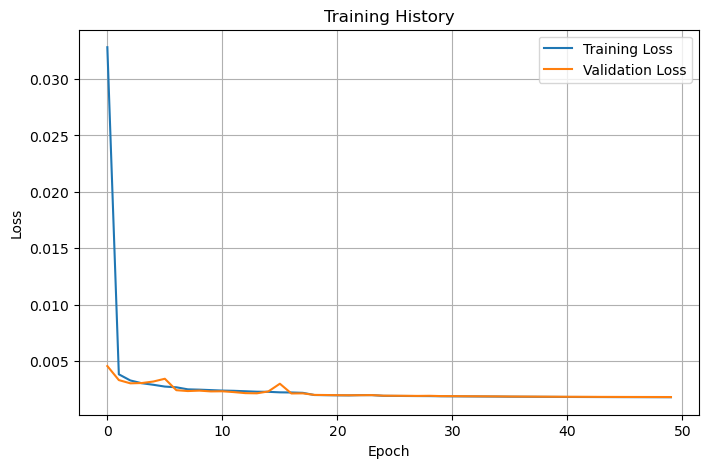

In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPU devices found:")
for gpu in gpus:
    print(gpu)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


def compile_and_prepare_model(model, initial_learning_rate=1e-3):
    
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse'
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=0.00001,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

lr_scheduler_I, early_stop_I = compile_and_prepare_model(my_model_I_in_I_out)

my_model_I_in_I_out.predict([past_currents_normalized[0:1,:,:], speed_array_pu[0:1,:], torque_array[0:1,:]])
print("Model structures passed, start training...")

# 開始訓練
#nromalized version
history_I = my_model_I_in_I_out.fit(
    x=[past_currents_normalized, speed_array_pu, torque_array], 
    y=past_currents_normalized,
    batch_size=256,
    epochs=50,
    validation_split=0.1, 
    callbacks=[lr_scheduler_I, early_stop_I] 
)

plt.figure(figsize=(8, 5))
plt.plot(history_I.history['loss'], label='Training Loss')
if 'val_loss' in history_I.history:
    plt.plot(history_I.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

metadata = {
    "model_name": model_name+'_I',
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "trained": True,
    "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

with open(os.path.join(model_path, model_name + '_I_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)
    

# 儲存模型    
my_model_I_in_I_out.save(os.path.join(model_path, model_name + '_I.keras'))


結果展示

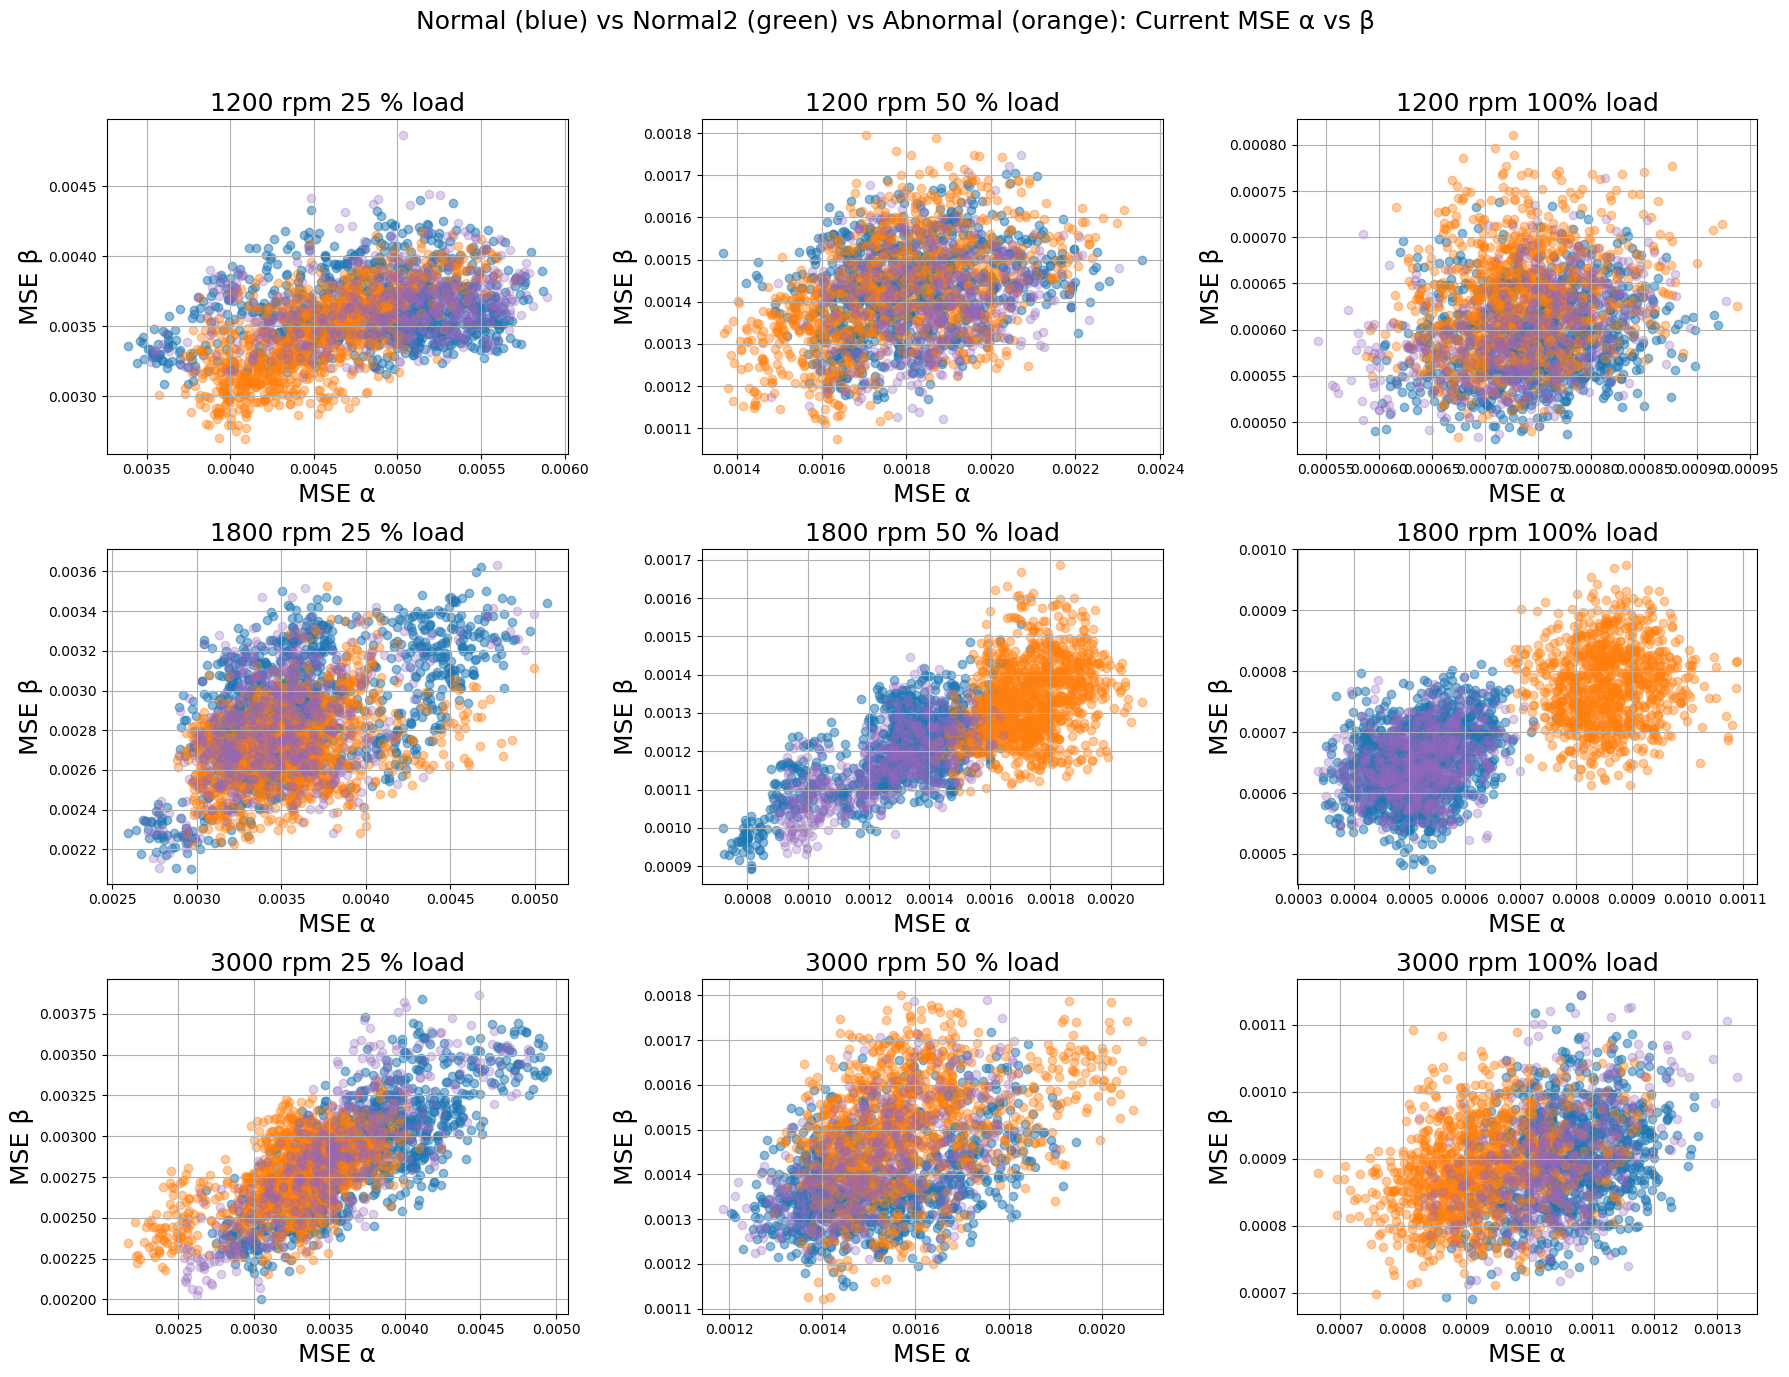

In [187]:
my_model_I_in_I_out= load_model(os.path.join(model_path, model_name + '_I.keras'))
# 畫出兩者間的分布圖（散點）
# Step 0: 定義 Condition Map
Condition_map = {
    '1200 0.5v': 'Condition 1',
    '1200 1.0v': 'Condition 2',
    '1200 2.0v': 'Condition 3',
    '1800 0.5v': 'Condition 4',
    '1800 1.0v': 'Condition 5',
    '1800 2.0v': 'Condition 6',
    '3000 0.5v': 'Condition 7',
    '3000 1.0v': 'Condition 8',
    '3000 2.0v': 'Condition 9',
}

Condition_map_spd_torque = {
    '1200 0.5v': '1200 rpm 25 % load',
    '1200 1.0v': '1200 rpm 50 % load',
    '1200 2.0v': '1200 rpm 100% load',
    '1800 0.5v': '1800 rpm 25 % load',
    '1800 1.0v': '1800 rpm 50 % load',
    '1800 2.0v': '1800 rpm 100% load',
    '3000 0.5v': '3000 rpm 25 % load',
    '3000 1.0v': '3000 rpm 50 % load',
    '3000 2.0v': '3000 rpm 100% load',
}

# # 計算重建MSE資料
normal_reconstruction_errors_current = {}
for folder in Normal_subfolders:
    recon = my_model_I_in_I_out.predict(
        [normal_datasets[folder]["input_signals_normalized"][:, :, 2:4],
         normal_datasets[folder]["speed_array_pu"],
         normal_datasets[folder]["torque_array"]],
        batch_size=128,verbose=0
    )
    mse_per_sample = np.mean((recon - normal_datasets[folder]["input_signals_normalized"][:, :, 2:4]) ** 2, axis=1)
    normal_reconstruction_errors_current[folder] = {
        "EMF_alpha_MSE": mse_per_sample[:, 0],
        "EMF_beta_MSE": mse_per_sample[:, 1]
    }

normal2_reconstruction_errors_current = {}
for folder in Normal2_subfolders:
    recon = my_model_I_in_I_out.predict(
        [normal2_datasets[folder]["input_signals_normalized"][:, :, 2:4],
         normal2_datasets[folder]["speed_array_pu"],
         normal2_datasets[folder]["torque_array"]],
        batch_size=128,verbose=0
    )
    mse_per_sample = np.mean((recon - normal2_datasets[folder]["input_signals_normalized"][:, :, 2:4]) ** 2, axis=1)
    normal2_reconstruction_errors_current[folder] = {
        "EMF_alpha_MSE": mse_per_sample[:, 0],
        "EMF_beta_MSE": mse_per_sample[:, 1]
    }
    
val_reconstruction_errors_current = {}
for folder in Normal_subfolders:
    recon = my_model_I_in_I_out.predict(
        [validation_datasets[folder]["input_signals_normalized"][:, :, 2:4],
         validation_datasets[folder]["speed_array_pu"],
         validation_datasets[folder]["torque_array"]],
        batch_size=128,verbose=0
    )
    mse_per_sample = np.mean((recon - validation_datasets[folder]["input_signals_normalized"][:, :, 2:4]) ** 2, axis=1)
    val_reconstruction_errors_current[folder] = {
        "EMF_alpha_MSE": mse_per_sample[:, 0],
        "EMF_beta_MSE": mse_per_sample[:, 1]
    }

      
abnormal_reconstruction_errors_current = {}
for folder in Abnormal_subfolders:
    recon = my_model_I_in_I_out.predict(
        [abnormal_datasets[folder]["input_signals_normalized"][:, :, 2:4],
         abnormal_datasets[folder]["speed_array_pu"],
         abnormal_datasets[folder]["torque_array"]],
        batch_size=128,verbose=0
    )
    mse_per_sample = np.mean((recon - abnormal_datasets[folder]["input_signals_normalized"][:, :, 2:4]) ** 2, axis=1)
    abnormal_reconstruction_errors_current[folder] = {
        "EMF_alpha_MSE": mse_per_sample[:, 0],
        "EMF_beta_MSE": mse_per_sample[:, 1]
    }

# normal_reconstruction_errors_current   = get_mse_from_folder(normal_datasets, Normal_subfolders, my_model_I_in_I_out)
# normal2_reconstruction_errors_current  = get_mse_from_folder(normal2_datasets, Normal2_subfolders, my_model_I_in_I_out)
# val_reconstruction_errors_current      = get_mse_from_folder(validation_datasets, Normal_subfolders, my_model_I_in_I_out)
# abnormal_reconstruction_errors_current = get_mse_from_folder(abnormal_datasets, Abnormal_subfolders, my_model_I_in_I_out)
# abnormal2_reconstruction_errors_current = get_mse_from_folder(abnormal2_datasets, abnormal2_subfolders, my_model_I_in_I_out)

# Step 2: 遍歷 Condition_map，為三個 dict 都找到 key 才算配對成功
matched_conditions = []
for cond_key in Condition_map:
    normal_key  = next((k for k in normal_reconstruction_errors_current  if cond_key in k), None)
    normal2_key = next((k for k in normal2_reconstruction_errors_current if cond_key in k), None)
    val_key = next((k for k in val_reconstruction_errors_current if cond_key in k), None)
    abnormal_key = next((k for k in abnormal_reconstruction_errors_current if cond_key in k), None)
    if normal_key and normal2_key and val_key and abnormal_key:
        matched_conditions.append((cond_key, normal_key, normal2_key, val_key, abnormal_key))


# BD results 
BD_abnromal_II = {}
BD_normal2_II = {}

# Step 3: 畫圖（散點）
num_folders = len(matched_conditions)
num_figs = int(np.ceil(num_folders / 9))

for fig_idx in range(num_figs):
    fig, axes = plt.subplots(3, 3, figsize=(18, 14))
    fig.suptitle("Normal (blue) vs Normal2 (green) vs Abnormal (orange): Current MSE α vs β", fontsize=18)

    for i in range(9):
        cond_idx = fig_idx * 9 + i
        if cond_idx >= num_folders:
            axes.flat[i].set_visible(False)
            continue

        cond_key, normal_key, normal2_key, val_key, abnormal_key = matched_conditions[cond_idx]
        ax = axes.flat[i]

        # Normal
        x_normal = normal_reconstruction_errors_current[normal_key]["EMF_alpha_MSE"]
        y_normal = normal_reconstruction_errors_current[normal_key]["EMF_beta_MSE"]

        # Normal2
        x_normal2 = normal2_reconstruction_errors_current[normal2_key]["EMF_alpha_MSE"]
        y_normal2 = normal2_reconstruction_errors_current[normal2_key]["EMF_beta_MSE"]

        # validation
        x_val = val_reconstruction_errors_current[val_key]["EMF_alpha_MSE"]
        y_val = val_reconstruction_errors_current[val_key]["EMF_beta_MSE"]

        # Abnormal
        x_abnormal = abnormal_reconstruction_errors_current[abnormal_key]["EMF_alpha_MSE"]
        y_abnormal = abnormal_reconstruction_errors_current[abnormal_key]["EMF_beta_MSE"]

        BD_abnormal=Bhattacharyya_distnace_2D(
            Guassian_2D_MLE(x_normal, y_normal)[0],
            Guassian_2D_MLE(x_normal, y_normal)[1],
            Guassian_2D_MLE(x_abnormal, y_abnormal)[0],
            Guassian_2D_MLE(x_abnormal, y_abnormal)[1]
        )
        BD_normal2= Bhattacharyya_distnace_2D(
            Guassian_2D_MLE(x_normal, y_normal)[0],
            Guassian_2D_MLE(x_normal, y_normal)[1],
            Guassian_2D_MLE(x_normal2, y_normal2)[0],
            Guassian_2D_MLE(x_normal2, y_normal2)[1]
        )
        BD_abnromal_II[f"Condition {i}" ] =BD_abnormal
        BD_normal2_II[f"Condition {i}"] =BD_normal2
        
        # 畫散點
        ax.scatter(x_normal,  y_normal,  label="Normal",  color='tab:blue',  alpha=0.5)
        # ax.scatter(x_normal2, y_normal2, label=f"Normal2 {BD_normal2:.4f}", color='tab:green', alpha=0.2)
        ax.scatter(x_abnormal,y_abnormal,label=f"Abnormal {BD_abnormal:.4f}",color='tab:orange',alpha=0.4)
        # ax.scatter(x_abnormal2, y_abnormal2, label=f"Abnormal2 {BD_abnormal2:.4f}", color='tab:cyan', alpha=0.5)
        ax.scatter(x_val, y_val, label="Validation", color='tab:purple', alpha=0.3)
        

        ax.set_xlabel("MSE α", fontsize=18)
        ax.set_ylabel("MSE β", fontsize=18)
        ax.set_title(Condition_map_spd_torque[cond_key], fontsize=18)
        ax.grid(True)
        # ax.legend(loc="best")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


V in I out 無條件

1/1 [==============================] - 0s 402ms/step


Model structures passed, start training...
開始訓練...
Epoch 1/50
275/275 [==============================] - 13s 39ms/step - loss: 0.0446 - val_loss: 0.0067 - lr: 0.0010
Epoch 2/50
275/275 [==============================] - 10s 37ms/step - loss: 0.0059 - val_loss: 0.0057 - lr: 0.0010
Epoch 3/50
275/275 [==============================] - 11s 40ms/step - loss: 0.0051 - val_loss: 0.0054 - lr: 0.0010
Epoch 4/50
275/275 [==============================] - 10s 38ms/step - loss: 0.0048 - val_loss: 0.0045 - lr: 0.0010
Epoch 5/50
275/275 [==============================] - 11s 38ms/step - loss: 0.0043 - val_loss: 0.0041 - lr: 0.0010
Epoch 6/50
275/275 [==============================] - 11s 40ms/step - loss: 0.0040 - val_loss: 0.0039 - lr: 0.0010
Epoch 7/50
275/275 [==============================] - 11s 40ms/step - loss: 0.0038 - val_loss: 0.0041 - lr: 0.0010
Epoch 8/50
275/275 [==============================] - 10s 36ms/step - loss: 0.0036 - val_loss: 0.0034 - lr: 0.0010
Epoch 9/50
275/275 [=========

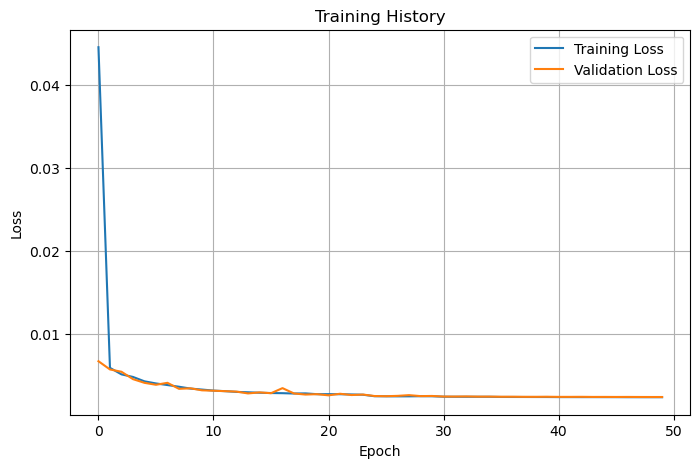

In [17]:
my_model_V_in_I_out_nocond
        
def compile_and_prepare_model(model, initial_learning_rate=1e-3):
    
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse',
        weighted_metrics=[]
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=1e-6,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

lr_scheduler_flux, early_stop_flux = compile_and_prepare_model(my_model_V_in_I_out_nocond)

# 測試模型結構是否正確
my_model_V_in_I_out_nocond.predict([ past_emf[0:1,:,:], speed_array_pu[0:1,:], torque_array[0:1,:]])  
#測試模型是否能夠正確讀取
my_model_V_in_I_out_nocond.save(os.path.join(model_path, model_name + 'nocond_Vi.keras'))
my_model_V_in_I_out_nocond= load_model(os.path.join(model_path, model_name + 'nocond_Vi.keras'))
print("Model structures passed, start training...")



# # 開始訓練
with tf.device('/GPU:0'):
    print("開始訓練...")
    history_VI = my_model_V_in_I_out_nocond.fit(
        x=[past_voltages_normalized, speed_array_pu, torque_array], 
        y=past_currents_normalized,
        batch_size=256,
        epochs=50,
        validation_split=0.1, 
        callbacks=[lr_scheduler_flux, early_stop_flux] 
    )

# history_flux = my_model_emf_in_emf_out.fit(
#     x=[past_emf, speed_array_pu, torque_array], 
#     y=future_emf,
#     batch_size=128,
#     epochs=50,
#     validation_split=0.1, 
#     callbacks=[lr_scheduler_flux, early_stop_flux] 
# )

plt.figure(figsize=(8, 5))
plt.plot(history_VI.history['loss'], label='Training Loss')
if 'val_loss' in history_VI.history:
    plt.plot(history_VI.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

my_model_V_in_I_out.save(os.path.join(model_path, model_name + '_VI.keras'))

metadata = {
    "model_name": model_name+'_VI',
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "trained": True,
    "train_loss": history_VI.history['loss'][-1],
    "val_loss": history_VI.history.get('val_loss', [None])[-1],
    "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

with open(os.path.join(model_path, model_name + '_nocond_VI_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)


Condition: 1200 0.5v, Normal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 0.5v  2kg cm2, Normal2 Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 0.5v  2kg cm2, Val Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 0.5v  2kg cm2, Abnormal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\wear-out-2(worse)\wear-out-2(worse) 1200 0.5v  2kg cm2
Condition: 1200 1.0v, Normal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 1.0v  2kg cm2, Normal2 Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 1.0v  2kg cm2, Val Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 1.0v  2kg cm2, Abnormal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\wear-out-2(worse)\wear-out-2(worse) 1200 1.0v  2kg cm2
Condition: 1200 2.0v, Normal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 2.0v  2kg cm2, Normal2 Key: D:\OneDrive\CCAE_experiments\CCAE_dataset

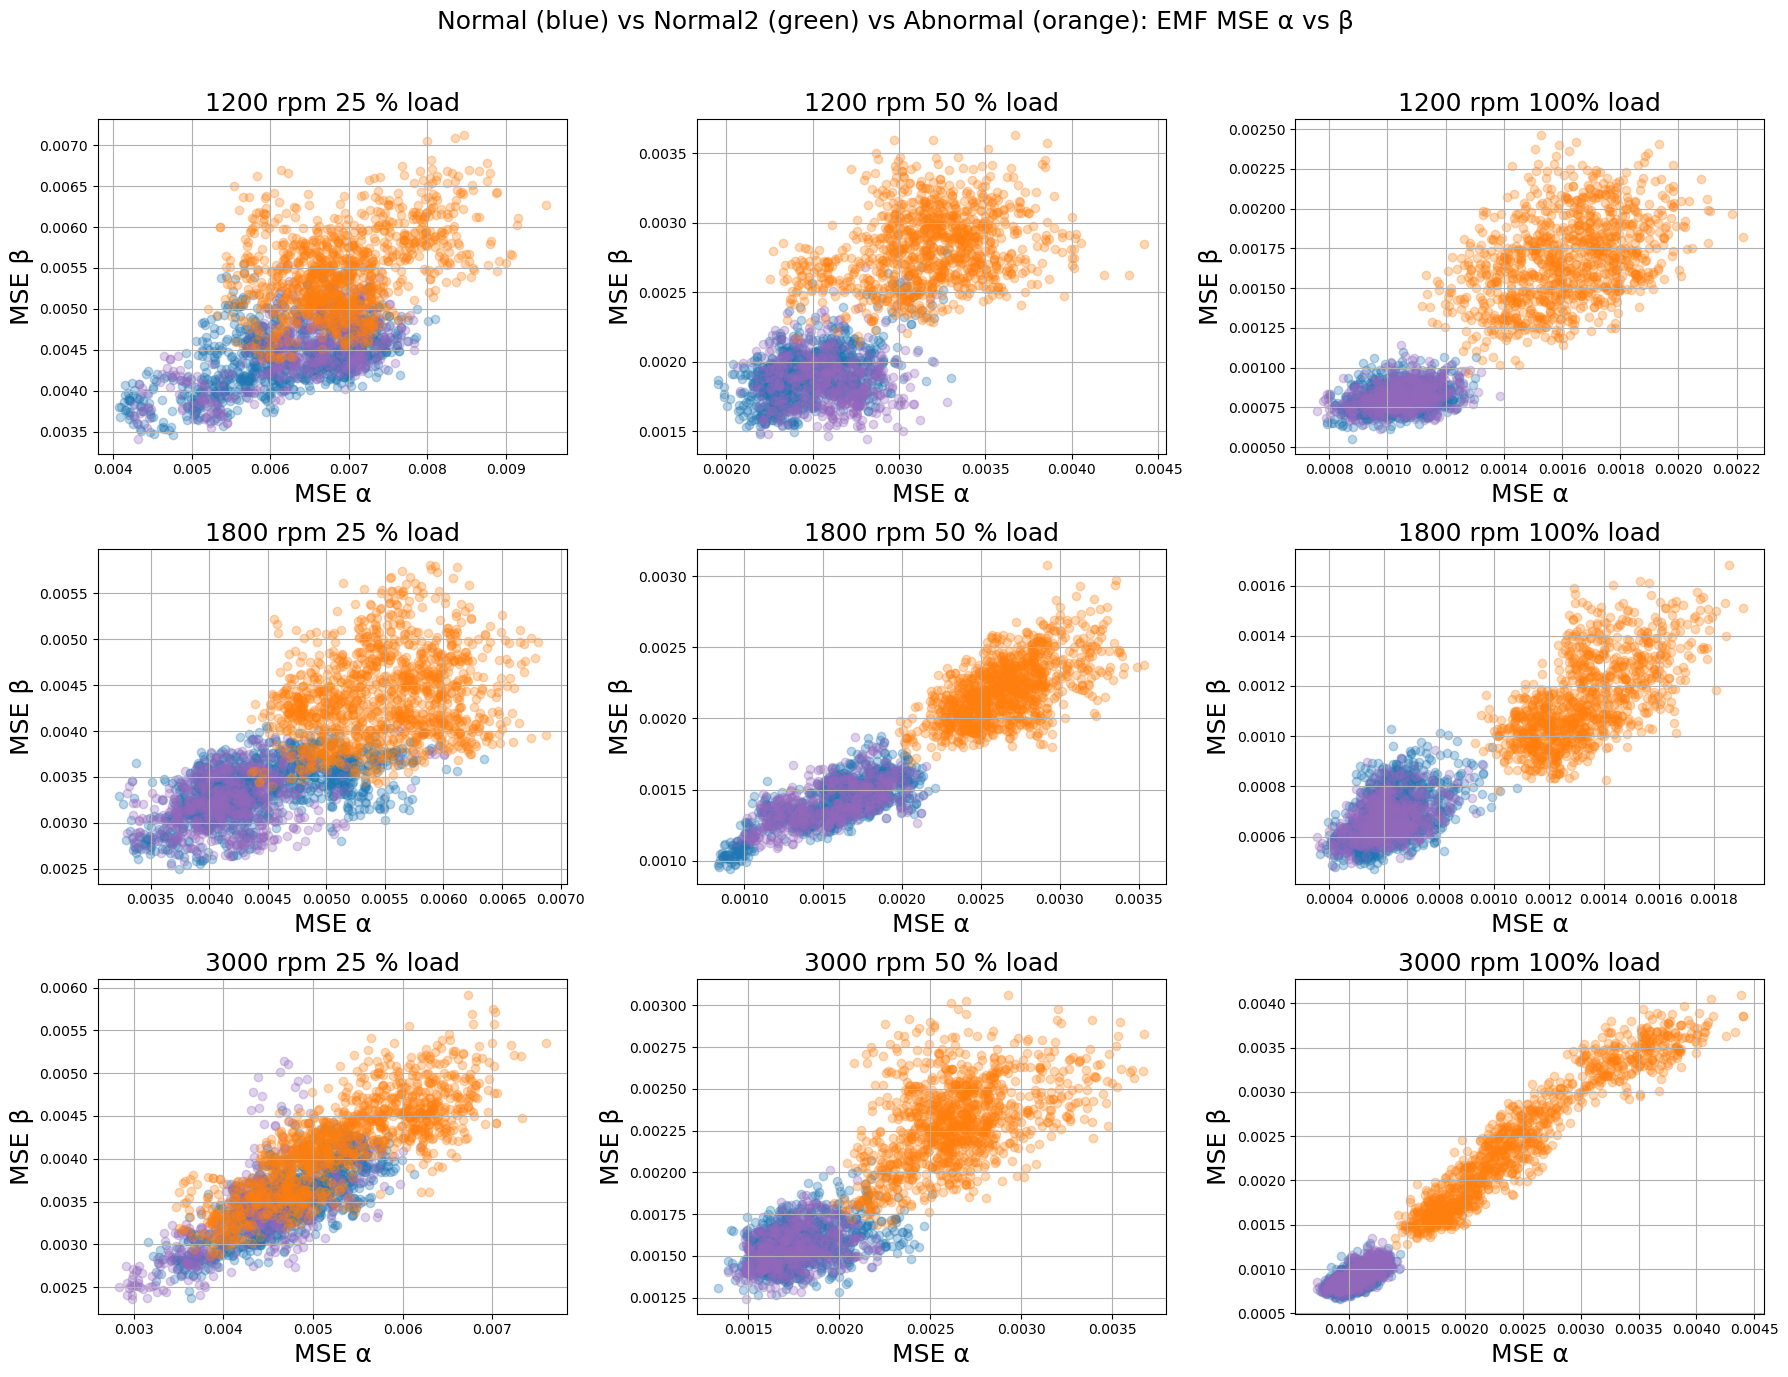

In [193]:
# my_model_V_in_I_out_nocond.save(os.path.join(model_path, model_name + '_nocond_VI.keras'))
# my_model_V_in_I_out_nocond=load_model(os.path.join(model_path, model_name + '_nocond_VI.keras'))
#計算重建MSE資料
normal_reconstruction_errors_VI = {}
for folder in Normal_subfolders:
    past_voltage_normalized= normal_datasets[folder]["input_signals_normalized"][:, :, 0:2]  # 使用過去的 emf 作為輸入
    future_current_normalized= normal_datasets[folder]["input_signals_normalized"][:, :, 2:4]
    # print(future_current_normalized.shape)
    reconstruction_errors_flux=my_model_V_in_I_out_nocond.predict(
        [past_voltage_normalized, 
        normal_datasets[folder]["speed_array_pu"], 
        normal_datasets[folder]["torque_array"]],
        batch_size=128,verbose=0)
    reconstruction_MSEs_flux_alpha = np.mean((future_current_normalized[:,:,0] - reconstruction_errors_flux[:,:,0])**2,axis=(1))
    reconstruction_MSEs_flux_beta = np.mean((future_current_normalized[:,:,1] - reconstruction_errors_flux[:,:,1])**2,axis=(1))
    normal_reconstruction_errors_VI[folder] = {"EMF_alpha_MSE": reconstruction_MSEs_flux_alpha,
                                                 "EMF_beta_MSE": reconstruction_MSEs_flux_beta}
    
normal2_reconstruction_errors_VI = {}
for folder in Normal2_subfolders:
    past_voltage_normalized= normal2_datasets[folder]["input_signals_normalized"][:, :, 0:2]  # 使用過去的 emf 作為輸入
    future_current_normalized= normal2_datasets[folder]["input_signals_normalized"][:, :, 2:4]
    # print(future_current_normalized.shape)
    reconstruction_errors_flux=my_model_V_in_I_out_nocond.predict(
        [past_voltage_normalized, 
        normal2_datasets[folder]["speed_array_pu"], 
        normal2_datasets[folder]["torque_array"]],
        batch_size=128,verbose=0)
    reconstruction_MSEs_flux_alpha = np.mean((future_current_normalized[:,:,0] - reconstruction_errors_flux[:,:,0])**2,axis=(1))
    reconstruction_MSEs_flux_beta = np.mean((future_current_normalized[:,:,1] - reconstruction_errors_flux[:,:,1])**2,axis=(1))
    normal2_reconstruction_errors_VI[folder] = {"EMF_alpha_MSE": reconstruction_MSEs_flux_alpha,
                                                 "EMF_beta_MSE": reconstruction_MSEs_flux_beta}

abnormal_reconstruction_errors_VI = {}
for folder in Abnormal_subfolders:
    past_voltage_normalized= abnormal_datasets[folder]["input_signals_normalized"][:, :, 0:2] 
    future_current_normalized= abnormal_datasets[folder]["input_signals_normalized"][:, :, 2:4]
    reconstruction_errors_flux=my_model_V_in_I_out_nocond.predict(
        [past_voltage_normalized, 
        abnormal_datasets[folder]["speed_array_pu"], 
        abnormal_datasets[folder]["torque_array"]],
        batch_size=128,verbose=0)
    reconstruction_MSEs_flux_alpha = np.mean((future_current_normalized[:,:,0] - reconstruction_errors_flux[:,:,0])**2,axis=(1))
    reconstruction_MSEs_flux_beta = np.mean((future_current_normalized[:,:,1] - reconstruction_errors_flux[:,:,1])**2,axis=(1))
    abnormal_reconstruction_errors_VI[folder] = {"EMF_alpha_MSE": reconstruction_MSEs_flux_alpha,
                                                 "EMF_beta_MSE": reconstruction_MSEs_flux_beta}
    
normal_reconstruction_errors_VI   = get_mse_from_folder(normal_datasets, Normal_subfolders, my_model_V_in_I_out_nocond)
normal2_reconstruction_errors_VI  = get_mse_from_folder(normal2_datasets, Normal2_subfolders, my_model_V_in_I_out_nocond)
val_reconstruction_errors_VI      = get_mse_from_folder(validation_datasets, Normal_subfolders, my_model_V_in_I_out_nocond)
abnormal_reconstruction_errors_VI = get_mse_from_folder(abnormal_datasets, Abnormal_subfolders, my_model_V_in_I_out_nocond)

# 畫出兩者間的分布圖
# Step 0: 定義 Condition Map
Condition_map = {
    '1200 0.5v': 'Condition 1',
    '1200 1.0v': 'Condition 2',
    '1200 2.0v': 'Condition 3',
    '1800 0.5v': 'Condition 4',
    '1800 1.0v': 'Condition 5',
    '1800 2.0v': 'Condition 6',
    '3000 0.5v': 'Condition 7',
    '3000 1.0v': 'Condition 8',
    '3000 2.0v': 'Condition 9',
}

# print(abnormal_reconstruction_errors_VI.items())


# Step 1: 遍歷 Condition_map，確保三種資料都有對應 key
matched_conditions = []
for cond_key in Condition_map:
    normal_key  = next((k for k in normal_reconstruction_errors_VI  if cond_key in k), None)
    normal2_key = next((k for k in normal2_reconstruction_errors_VI if cond_key in k), None)
    val_key = next((k for k in val_reconstruction_errors_VI if cond_key in k), None)
    abnormal_key = next((k for k in abnormal_reconstruction_errors_VI if cond_key in k), None)

    print(f"Condition: {cond_key}, Normal Key: {normal_key}, Normal2 Key: {normal2_key}, Val Key: {val_key}, Abnormal Key: {abnormal_key}")

    if normal_key and normal2_key and val_key and abnormal_key:
        matched_conditions.append((cond_key, normal_key, normal2_key, val_key, abnormal_key))

# Step 2: 畫圖（散點圖）
num_folders = len(matched_conditions)
num_figs = int(np.ceil(num_folders / 9))

# BD results 
BD_abnromal_VI_nocond = {}
BD_normal2_VI = {}

for fig_idx in range(num_figs):
    fig, axes = plt.subplots(3, 3, figsize=(18, 14))
    fig.suptitle("Normal (blue) vs Normal2 (green) vs Abnormal (orange): EMF MSE α vs β", fontsize=18)

    for i in range(9):
        cond_idx = fig_idx * 9 + i
        if cond_idx >= num_folders:
            axes.flat[i].set_visible(False)
            continue

        cond_key, normal_key, normal2_key, val_key, abnormal_key = matched_conditions[cond_idx]
        ax = axes.flat[i]

        # Normal
        x_normal = normal_reconstruction_errors_VI[normal_key]["EMF_alpha_MSE"]
        y_normal = normal_reconstruction_errors_VI[normal_key]["EMF_beta_MSE"]

        # Validation
        x_val = val_reconstruction_errors_VI[val_key]["EMF_alpha_MSE"]
        y_val = val_reconstruction_errors_VI[val_key]["EMF_beta_MSE"]

        # Normal2
        x_normal2 = normal2_reconstruction_errors_VI[normal2_key]["EMF_alpha_MSE"]
        y_normal2 = normal2_reconstruction_errors_VI[normal2_key]["EMF_beta_MSE"]

        # Abnormal
        x_abnormal = abnormal_reconstruction_errors_VI[abnormal_key]["EMF_alpha_MSE"]
        y_abnormal = abnormal_reconstruction_errors_VI[abnormal_key]["EMF_beta_MSE"]
        
        BD_abnormal=Bhattacharyya_distnace_2D(
            Guassian_2D_MLE(x_normal, y_normal)[0],
            Guassian_2D_MLE(x_normal, y_normal)[1],
            Guassian_2D_MLE(x_abnormal, y_abnormal)[0],
            Guassian_2D_MLE(x_abnormal, y_abnormal)[1]
        )
        BD_normal2= Bhattacharyya_distnace_2D(
            Guassian_2D_MLE(x_normal, y_normal)[0],
            Guassian_2D_MLE(x_normal, y_normal)[1],
            Guassian_2D_MLE(x_normal2, y_normal2)[0],
            Guassian_2D_MLE(x_normal2, y_normal2)[1]
        )
        
        # 計算BD
        BD_abnromal_VI_nocond[f"Condition {i}" ] =BD_abnormal
        BD_normal2_VI[f"Condition {i}"] =BD_normal2
        # 畫散點
        
        ax.scatter(x_normal,  y_normal,  label="Normal",  color='tab:blue',  alpha=0.3)
        ax.scatter(x_val, y_val, label="Validation", color='tab:purple', alpha=0.3)
        # ax.scatter(x_normal2, y_normal2, label=f"Normal2 {BD_normal2:.4f}", color='tab:green', alpha=0.2)
        ax.scatter(x_abnormal,y_abnormal,label=f"Abnormal {BD_abnormal:.4f}",color='tab:orange',alpha=0.3)

        ax.set_xlabel("MSE α", fontsize=18)
        ax.set_ylabel("MSE β", fontsize=18)
        # ax.legend(loc="best", prop={"family": "Times New Roman", "size": 14})
        ax.set_title(Condition_map_spd_torque[cond_key], fontsize=18)
        ax.grid(True)
        # ax.legend(loc="best")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

10/10 [==============================] - 0s 11ms/step


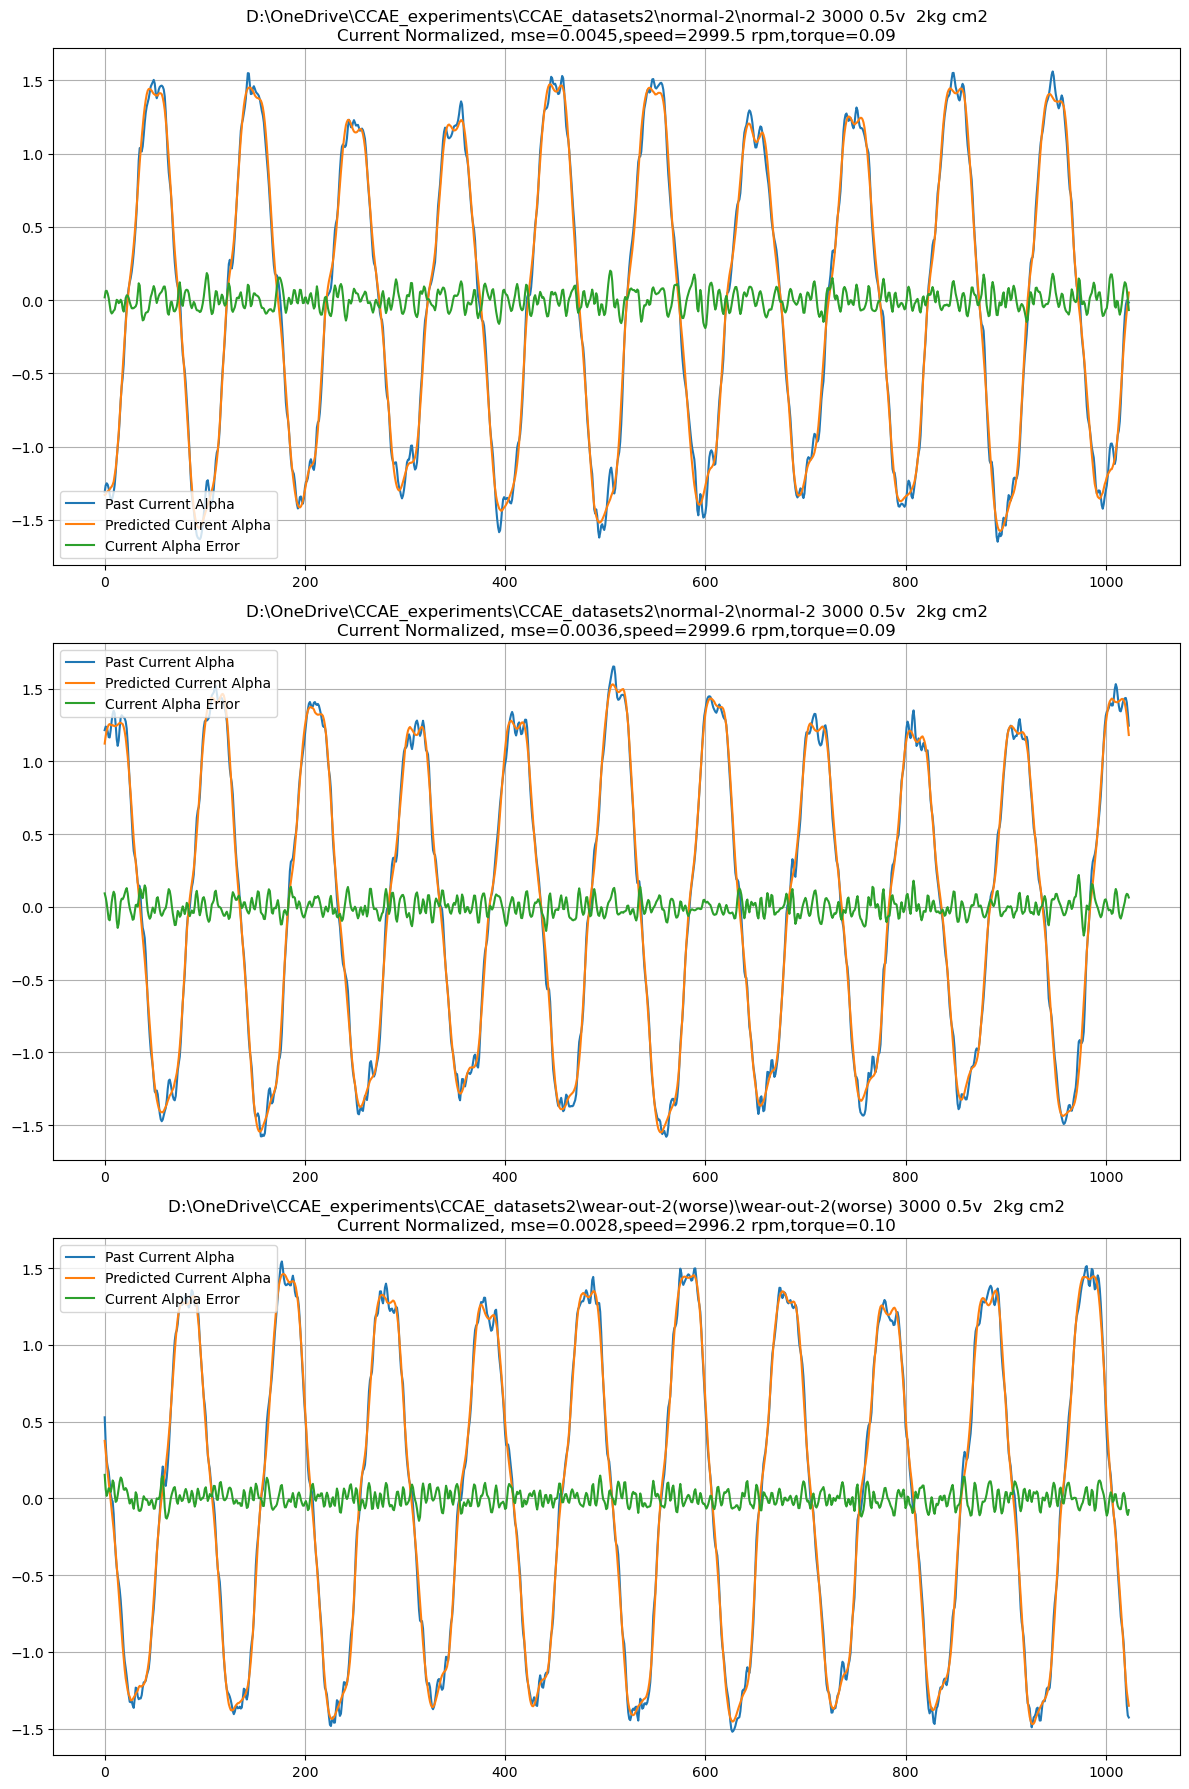

In [ ]:
condition_number=6

check_past_emf_normal= normal_datasets[Normal_subfolders[condition_number]]["input_signals_normalized"][:, :, 2:4]  # 使用過去的 emf 作為輸入
check_reconstruction_normal=my_model_I_in_I_out.predict(
    [check_past_emf_normal, 
    normal_datasets[Normal_subfolders[condition_number]]["speed_array_pu"], 
    normal_datasets[Normal_subfolders[condition_number]]["torque_array"]],
    batch_size=128)

check_past_emf_normal2= normal2_datasets[Normal2_subfolders[condition_number]]["input_signals_normalized"][:, :, 2:4]  # 使用過去的 emf 作為輸入
check_reconstruction_normal2=my_model_I_in_I_out.predict(
    [check_past_emf_normal2, 
    normal2_datasets[Normal2_subfolders[condition_number]]["speed_array_pu"], 
    normal2_datasets[Normal2_subfolders[condition_number]]["torque_array"]],
    batch_size=128)

check_past_emf_abnormal= abnormal_datasets[Abnormal_subfolders[condition_number]]["input_signals_normalized"][:, :, 2:4]  # 使用過去的 emf 作為輸入
check_reconstruction_abnormal=my_model_I_in_I_out.predict(
    [check_past_emf_abnormal, 
    abnormal_datasets[Abnormal_subfolders[condition_number]]["speed_array_pu"], 
    abnormal_datasets[Abnormal_subfolders[condition_number]]["torque_array"]],
    batch_size=128)

fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Normal
axs[0].plot(range(sequence_length), check_past_emf_normal[0, :, 0], label='Past Current Alpha')
axs[0].plot(range(sequence_length), check_reconstruction_normal[0, :, 0], label='Predicted Current Alpha')
error = check_past_emf_normal[0, :, 0] - check_reconstruction_normal[0, :, 0]
axs[0].plot(range(sequence_length), error, label='Current Alpha Error')
axs[0].set_title(
    f'{Normal_subfolders[condition_number]}\n'
    f'Current Normalized, mse={np.mean(np.square(error)):.4f},'
    f'speed={normal_datasets[Normal_subfolders[condition_number]]["speed_array_pu"][0, 0]*3000:.1f} rpm,'
    f'torque={normal_datasets[Normal_subfolders[condition_number]]["torque_array"][0, 0]:.2f}'
)
axs[0].legend()
axs[0].grid(True)

# Normal2
axs[1].plot(range(sequence_length), check_past_emf_normal2[0, :, 0], label='Past Current Alpha')
axs[1].plot(range(sequence_length), check_reconstruction_normal2[0, :, 0], label='Predicted Current Alpha')
error = check_past_emf_normal2[0, :, 0] - check_reconstruction_normal2[0, :, 0]
axs[1].plot(range(sequence_length), error, label='Current Alpha Error')
axs[1].set_title(
    f'{Normal2_subfolders[condition_number]}\n'
    f'Current Normalized, mse={np.mean(np.square(error)):.4f},'
    f'speed={normal2_datasets[Normal2_subfolders[condition_number]]["speed_array_pu"][0, 0]*3000:.1f} rpm,'
    f'torque={normal2_datasets[Normal2_subfolders[condition_number]]["torque_array"][0, 0]:.2f}'
)
axs[1].legend()
axs[1].grid(True)

# Abnormal
axs[2].plot(range(sequence_length), check_past_emf_abnormal[0, :, 0], label='Past Current Alpha')
axs[2].plot(range(sequence_length), check_reconstruction_abnormal[0, :, 0], label='Predicted Current Alpha')
error = check_past_emf_abnormal[0, :, 0] - check_reconstruction_abnormal[0, :, 0]
axs[2].plot(range(sequence_length), error, label='Current Alpha Error')
axs[2].set_title(
    f'{Abnormal_subfolders[condition_number]}\n'
    f'Current Normalized, mse={np.mean(np.square(error)):.4f},'
    f'speed={abnormal_datasets[Abnormal_subfolders[condition_number]]["speed_array_pu"][0, 0]*3000:.1f} rpm,'
    f'torque={abnormal_datasets[Abnormal_subfolders[condition_number]]["torque_array"][0, 0]:.2f}'
)
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
BD_abnromal_II

{'Condition 0': 0.1333470504935527,
 'Condition 1': 0.041695357444364006,
 'Condition 2': 0.15615523861997505,
 'Condition 3': 0.04004555460992776,
 'Condition 4': 1.9662127256679882,
 'Condition 5': 2.912325846327512,
 'Condition 6': 0.23352180399405445,
 'Condition 7': 0.35758142364647316,
 'Condition 8': 2.469822121030745}

In [ ]:
val_subfolders = list_subfolders(validation_folder_path)
for folder in val_subfolders:
    print(folder)

D:\OneDrive\CCAE_experiments\CCAE_datasets2\validation\normal-2 1200 0.5v  2kg cm2
D:\OneDrive\CCAE_experiments\CCAE_datasets2\validation\normal-2 1200 1.0v  2kg cm2
D:\OneDrive\CCAE_experiments\CCAE_datasets2\validation\normal-2 1200 2.0v  2kg cm2
D:\OneDrive\CCAE_experiments\CCAE_datasets2\validation\normal-2 1800 0.5v  2kg cm2
D:\OneDrive\CCAE_experiments\CCAE_datasets2\validation\normal-2 1800 1.0v  2kg cm2
D:\OneDrive\CCAE_experiments\CCAE_datasets2\validation\normal-2 1800 2.0v  2kg cm2
D:\OneDrive\CCAE_experiments\CCAE_datasets2\validation\normal-2 3000 0.5v  2kg cm2
D:\OneDrive\CCAE_experiments\CCAE_datasets2\validation\normal-2 3000 1.0v  2kg cm2
D:\OneDrive\CCAE_experiments\CCAE_datasets2\validation\normal-2 3000 2.0v  2kg cm2


### Performance 比較 ###

condition Condition 0 vals [0.18848583088157733, 0.7687829736103718, 1.0412687396344662]
condition Condition 1 vals [0.028564366365079197, 2.2050436452767785, 3.563871877318984]
condition Condition 2 vals [0.09782616274788103, 3.479668059367617, 4.280303979092471]
condition Condition 3 vals [0.11099401400755127, 1.1294575193630205, 1.4853433086611023]
condition Condition 4 vals [0.9673407741575758, 2.346079208272144, 2.0634210372004964]
condition Condition 5 vals [3.1698430413007554, 3.191943504120083, 3.845952433558674]
condition Condition 6 vals [0.20020284750888528, 0.2923022234699649, 0.617334801069563]
condition Condition 7 vals [0.15991561731793255, 2.2761976386559426, 2.4760975402342567]
condition Condition 8 vals [0.3898228423211764, 1.9357795248895209, 2.2658235325642337]


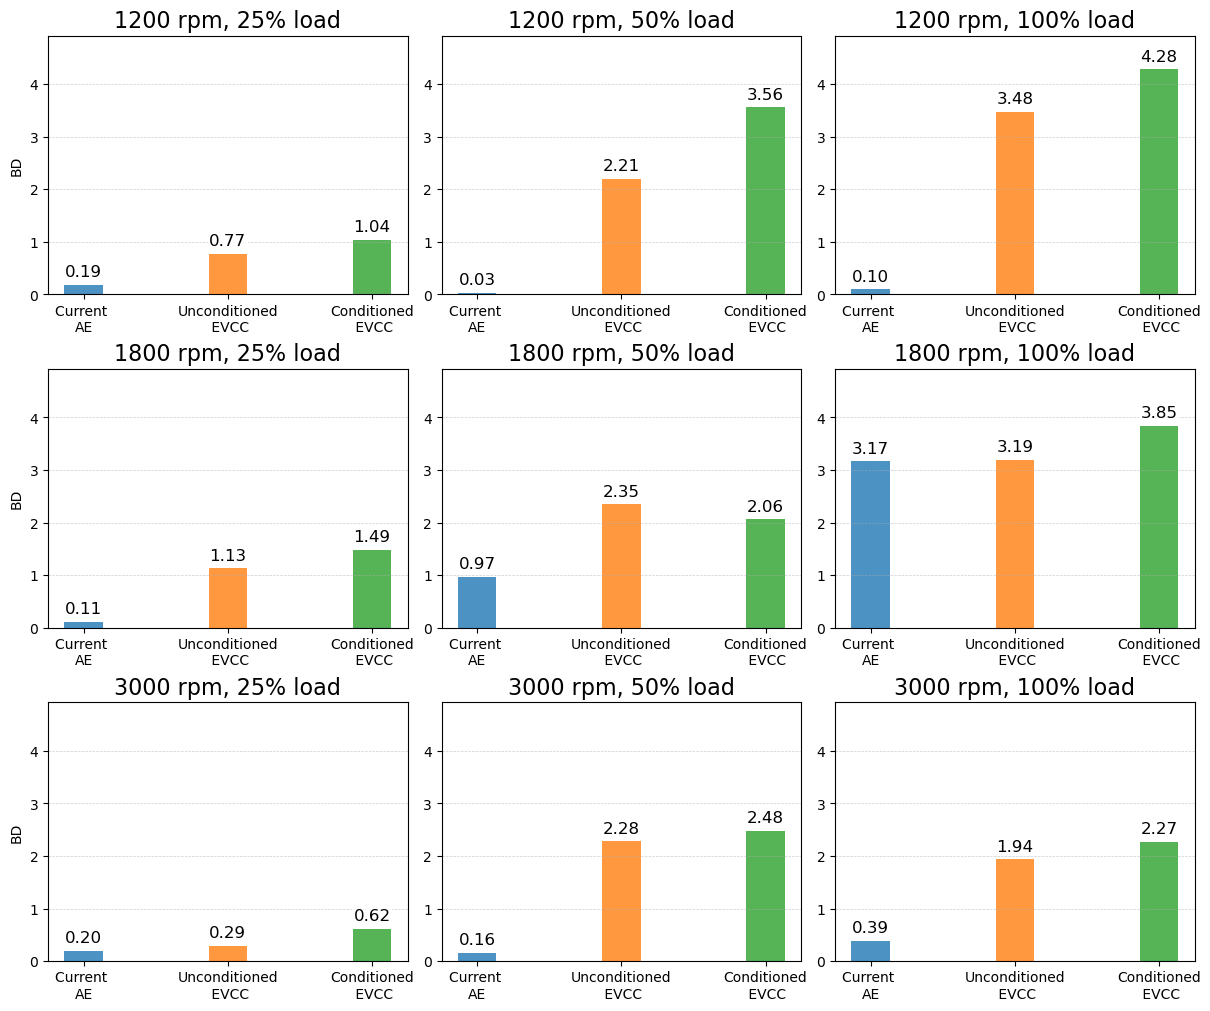

In [188]:
import matplotlib.pyplot as plt
import numpy as np

# ===== 可放任意筆進來；鍵名會當成每格裡的分類標籤 =====
datasets = {
    "Current \nAE": BD_abnromal_II,
    "Unconditioned\n EVCC": BD_abnromal_VI_nocond,
    "Conditioned\n EVCC": BD_abnromal_VI,
}

Condition_map = {
    '1200 0.5v': 'Condition 0',
    '1200 1.0v': 'Condition 1',
    '1200 2.0v': 'Condition 2',
    '1800 0.5v': 'Condition 3',
    '1800 1.0v': 'Condition 4',
    '1800 2.0v': 'Condition 5',
    '3000 0.5v': 'Condition 6',
    '3000 1.0v': 'Condition 7',
    '3000 2.0v': 'Condition 8',
}

speeds   = [1200, 1800, 3000]
voltages = [0.5, 1.0, 2.0]
loads = {"0.5": "25%", "1.0": "50%", "2.0": "100%"}

# voltages = [2.0, 1.0, 0.5]

# ===== 預先掃描統一 y 軸上限 =====
all_vals = []
for s in speeds:
    for v in voltages:
        cond = Condition_map[f"{s} {v}v"]
        for name, d in datasets.items():
            all_vals.append(float(d.get(cond, 0.0)))
ymax = max(all_vals) if all_vals else 1.0
ymax *= 1.15  # 上方留白

# =====（可選）指定顏色：IEEE 藍/橘/灰；如不需要就維持預設色盤 =====
# color_map = {
#     "VI": "#1f77b4",   # IEEE Blue
#     "II": "#ff7f0e",   # IEEE Orange
#     "III": "#7f7f7f",  # Gray
# }

# ===== 繪圖：九宮格，每格分組長條圖 =====
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(12, 10), constrained_layout=True)
names = list(datasets.keys())
n_groups = len(names)
bar_width = 0.8 / max(n_groups, 1)

for i, s in enumerate(speeds):
    for j, v in enumerate(voltages):
        ax = axes[i, j]
        cond = Condition_map[f"{s} {v}v"]
        vals = [float(datasets[name].get(cond, 0.0)) for name in names]

        print(f'condition {cond} vals {vals}' )
        # 分組位置：每組一個柱
        x = np.arange(n_groups)
        for k, val in enumerate(vals):
            # color = color_map.get(names[k], None) if 'color_map' in globals() else None
            ax.bar(x[k], val, width=bar_width, alpha=0.8)  # , color=color

            # 柱頂數值標籤（白底粗體）
            ax.text(
                x[k],
                val + 0.02 * ymax,
                f"{val:.2f}",
                ha="center",
                va="bottom",
                fontsize=12,
                # fontweight="bold",
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.85, pad=1),
            )

        ax.set_ylim(0, ymax)
        ax.set_xticks(x)
        ax.set_xticklabels(names)
        load = loads.get(str(v), "Unknown")
        ax.set_title(f"{s} rpm, {load} load", fontsize=16)
        ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

# 共享總標題與 y 標籤（避免中文字型缺字問題，可改回中文）
# fig.suptitle("2D 3x3 Grid: Per-Condition Grouped Bars of BD Values", fontsize=14, fontweight="bold")
# fig.text(0.5, 0.01, "Dataset", ha="center", fontsize=11)
# fig.text(0.01, 0.5, "Value", va="center", rotation="vertical", fontsize=11)

# 建立共享圖例（取第一格的柱標籤）
# 若需要自訂顏色，可在上方 color_map 區塊開啟後，另外建立 legend patches。
handles = [plt.Rectangle((0,0),1,1) for _ in names]
# axes[0,0].legend(handles, names, loc="upper right", fontsize=9, frameon=True)
axes[0, 0].set_ylabel("BD")
axes[1, 0].set_ylabel("BD")
axes[2, 0].set_ylabel("BD")
plt.show()


### 導入 RUL 資料 ###

In [ ]:
print(n_groups)

3
